In [130]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import re
import psycopg2
import json
import math
import datetime
from sqlalchemy import create_engine
import seaborn as sb

import pprint
pp = pprint.PrettyPrinter(indent=4)

from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
import scipy.stats
import ipywidgets as widgets

from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, plot_confusion_matrix, balanced_accuracy_score
import joblib
import requests
import seaborn as sb

from IPython.core.display import HTML
from urllib.parse import urlparse, parse_qs
pd.options.display.max_columns = 150
pd.options.display.max_rows = 150
HTML("<style>.container { width:100% !important; }</style>")

In [2]:
raw_data = pd.read_excel('raw_data/2022-02-25 Verbatims Peiling Dec 21.xlsx')
print(f'{len(raw_data)} number of rows in the dataset')
raw_data.sample()

1015 number of rows in the dataset


,Respondent_Serial,Geslacht,Leeftijd,Leeftijd categorie,Provincie,Habitat,Opleiding detail,Opleiding algemeen,Beroep detail,Beroep algemeen,Q5: Stemgerechtigd,Q6: Groen potentieel,Q6: CD&V potentieel,Q6: N-VA potentieel,Q6: Vooruit potentieel,Q6: VB potentieel,Q6: Open VLD potentieel,Q6: PVDA potentieel,Q7: voorkeur,Q9: aversie,Q10: stem 2019,Q12: reden switch,Q42: stemmen bij afschaffen opkomstplicht gemeenteraadsverkiezingen,Q15: Ideologische zelfpositionering links/rechts,Q23: Belang thema's - open,Q21: Belang thema’s,Q64: Klimaat - Thema eerst,Q65: Klimaat - Thema tweede,Q64: Migratie - Thema eerst,Q65: Migratie - Thema tweede,Q64: Sociale zekerheid - Thema eerst,Q65: Sociale zekerheid - Thema tweede,Q64: Pensioenen - Thema eerst,Q65: Pensioenen - Thema tweede,Q64: Gezondheidszorg - Thema eerst,Q65: Gezondheidszorg - Thema tweede,Q64: Werkgelegenheid - Thema eerst,Q65: Werkgelegenheid - Thema tweede,Q26: Beleid corona,Q43: Gevaccineerd,Q66: Vertrouwen 1,Q67: Vertrouwen 2,Q68: Vertrouwen 3,Q44: Ongelijkheid 1,Q45: Ongelijkheid 2,Q46: Ongelijkheid 3,Q47: Klimaat 1,Q48: Klimaat 2,Q49: Klimaat 3,Q50: Migratie 1,Q51: Migratie 2,Q52: Migratie 3,Q53: Verzorgingsstaat/Overheid 1,Q54: Verzorgingsstaat/Overheid 2,Q55: Vlaanderen / België,Q56: Veiligheid,Q57: Bewust 1,Q58: Bewust 2,Q59: Bewust 3,Q60: Houding tav politiek / democratie 1,Q61: Houding tav politiek / democratie 2,Q62: Houding tav politiek / democratie 3,Q28: Conner Rousseau - bekend,Q28: Meryame Kitir - bekend,Q28: Frank Vandenbroucke - bekend,Q28: Vincent Van Quickenborne - bekend,Q28: Alexander De Croo - bekend,Q28: Bart Somers - bekend,Q28: Egbert Lachaert - bekend,Q28: Hilde Crevits - bekend,Q28: Joachim Coens - bekend,Q28: Wouter Beke - bekend,Q28: Petra De Sutter - bekend,Q28: Tom Van Grieken - bekend,Q28: Dries Van Langenhove - bekend,Q28: Bart De Wever - bekend,Q28: Jan Jambon - bekend,Q28: Theo Francken - bekend,Q28: Ben Weyts - bekend,Q28: Zuhal Demir - bekend,Q28: Sammy Mahdi - bekend,Q28: Raoul Hedebouw - bekend,Q28: Tinne Van der Straeten - bekend,Q29: Conner Rousseau - potentieel,Q29: Meryame Kitir - potentieel,Q29: Frank Vandenbroucke - potentieel,Q29: Vincent Van Quickenborne - potentieel,Q29: Alexander De Croo - potentieel,Q29: Bart Somers - potentieel,Q29: Egbert Lachaert - potentieel,Q29: Hilde Crevits - potentieel,Q29: Joachim Coens - potentieel,Q29: Wouter Beke - potentieel,Q29: Petra De Sutter - potentieel,Q29: Tom Van Grieken - potentieel,Q29: Dries Van Langenhove - potentieel,Q29: Bart De Wever - potentieel,Q29: Jan Jambon - potentieel,Q29: Theo Francken - potentieel,Q29: Ben Weyts - potentieel,Q29: Zuhal Demir - potentieel,Q29: Sammy Mahdi - potentieel,Q29: Raoul Hedebouw - potentieel,Q29: Tinne Van der Straeten - potentieel,Q32: Frank Vandenbroucke - Indruk ministers,Q32: Alexander De Croo - Indruk ministers,Q32: Wouter Beke - Indruk ministers,Q32: Jan Jambon - Indruk ministers,Q32: Ben Weyts - Indruk ministers,Q33: Joris Vandenbroucke - bekend,Q33: Freya Vandenbossche - bekend,Q33: Astrid De Bruycker - bekend,Q33: Maxim Veys - bekend,Q33: Melissa Depraetere - bekend,Q33: Steve Vandenberghe - bekend,Q33: Annick Lambrecht - bekend,Q33: Bruno Tobback - bekend,Q33: Karin Jiroflee - bekend,Q33: Mohamed Ridouani - bekend,Q33: Kris Verduyckt - bekend,Q33: Ludwig Vandenhove - bekend,Q33: Els Robeyns - bekend,Q33: Tom Meeuws - bekend,Q33: Hannes Anaf - bekend,Q33: Caroline Gennez - bekend,Q33: Hannelore Goeman - bekend,Q33: Pablo Anys - bekend,Q36: Positieve woorden Vooruit,Q37: Negatieve woorden Vooruit,Q63: Vooruit is een partij die opkomt voor mensen zoals ik,Q63: Vooruit communiceert over het algemeen goed over haar standpunten en beleid,Q63: Vooruit heeft over het algemeen goede ideeën en voorstellen,Q63: Vooruit slaagt er over het algemeen goed in haar ideeën en voorstellen daadwerkelijk te realiseren,Q41: Inkomen
957,1213,Vrouw,68,65+,Oost-Vlaanderen,Steden,hoger algemeen secundair onderwijs,hoger secundair onderwijs,Gepensioneerde,gepensioneerd,

In [5]:
data_cleaned = raw_data.copy()

data_cleaned['Opleiding algemeen'] = data_cleaned['Opleiding algemeen'].replace('hoger onderwijs (kandidaat, licentiaat, bachelor, master, ...)', '3 hoger onderwijs')
data_cleaned['Opleiding algemeen'] = data_cleaned['Opleiding algemeen'].replace('hoger secundair onderwijs', '2 hoger secundar onderwijs')
data_cleaned['Opleiding algemeen'] = data_cleaned['Opleiding algemeen'].replace('lager of lager secundair onderwijs', '1 lager secundar onderwijs')
data_cleaned['Opleiding algemeen'] = data_cleaned['Opleiding algemeen'].replace('weet niet - geef liever geen antwoord', np.nan)

data_cleaned['Opleiding_num'] = data_cleaned['Opleiding detail'].copy()
data_cleaned['Opleiding_num'] = data_cleaned['Opleiding_num'].replace('lagere school of geen diploma', 1)
data_cleaned['Opleiding_num'] = data_cleaned['Opleiding_num'].replace('lager TSO, BSO of artistiek (1ste 3 jaar)', 2)
data_cleaned['Opleiding_num'] = data_cleaned['Opleiding_num'].replace('lager algemeen secundair onderwijs (1ste 3 jaar)', 2)
data_cleaned['Opleiding_num'] = data_cleaned['Opleiding_num'].replace('hoger secundair beroepsonderwijs (BSO)', 3)
data_cleaned['Opleiding_num'] = data_cleaned['Opleiding_num'].replace('hoger secundair technisch of artistiek onderwijs', 3)
data_cleaned['Opleiding_num'] = data_cleaned['Opleiding_num'].replace('hoger algemeen secundair onderwijs', 3)
data_cleaned['Opleiding_num'] = data_cleaned['Opleiding_num'].replace('kandidaat, bachelor, graduaat', 4)
data_cleaned['Opleiding_num'] = data_cleaned['Opleiding_num'].replace('licentiaat, master, postgraduaat', 5)
data_cleaned['Opleiding_num'] = data_cleaned['Opleiding_num'].replace('licentiaat met aanvullend diploma, MaNaMa', 5)
data_cleaned['Opleiding_num'] = data_cleaned['Opleiding_num'].replace('doctoraat met thesis', 6)
data_cleaned['Opleiding_num'] = data_cleaned['Opleiding_num'].replace('geef liever geen antwoord', np.nan)

data_cleaned['Inkomen_num'] = data_cleaned['Q41: Inkomen']
data_cleaned['Inkomen_num'] = data_cleaned['Inkomen_num'].replace({
        'weet niet':np.nan,
        '€ 0 - € 1000':1,
        '€ 1500 - € 2000':2,
        '€ 2000 - € 2500':3, 
        '€ 2500 - € 3000':4,
        '€ 3000 - € 3500':5, 
        '€ 1000 - € 1500':6, 
        '€ 3500 - € 4000':7,
        '€ 4000 - € 4500':8, 
        '€ 4500 - € 5000':9, 
        '>€ 5000':10})

data_cleaned['Beroep algemeen'] = data_cleaned['Beroep algemeen'].replace('niet beroepsactief (huisman, -vrouw, werkloos, student, ...)', 'niet beroepsactief')
data_cleaned['Beroep algemeen'] = data_cleaned['Beroep algemeen'].replace('weet niet - geef liever geen antwoord', np.nan)

# Respondenten die op de vragen met score 0-7 altijd 4 antwoorden eruit gooien
columns_with_0_to_7_score = []
for c in data_cleaned.columns:
    if not(data_cleaned[c].dtype == np.float64 or data_cleaned[c].dtype == np.int64):continue
    if not((data_cleaned[c].min()==1) & (data_cleaned[c].max()==7)):continue
    if not len(np.unique(data_cleaned[c]))==7:continue
    columns_with_0_to_7_score.append(c)
row_mask = (data_cleaned[columns_with_0_to_7_score]==4).mean(axis=1)==1
print(f'Verwijderen van {sum(row_mask)} respondenten die op vragen met scores 0-7 steeds 4 antwoorden')
data_cleaned = data_cleaned.loc[~row_mask,:].copy()    

# Clean up some values in columns
data_cleaned['Q7: voorkeur'] = data_cleaned['Q7: voorkeur'].replace({'Vooruit (vroeger sp.a)': 'Vooruit'})

# Clean up values potentieel partijen
kolommen_potienteel_partijen = ['Q6: PVDA potentieel',
                                'Q6: Groen potentieel', 
                               'Q6: Vooruit potentieel',
                                'Q6: CD&V potentieel',
                                'Q6: Open VLD potentieel',
                                'Q6: N-VA potentieel',
                               'Q6: VB potentieel']
data_cleaned[kolommen_potienteel_partijen] = data_cleaned[kolommen_potienteel_partijen].replace({'Nee': -1, 'Ja':1})

# Create a column partij vandaag
data_cleaned['Partij_vandaag'] = data_cleaned['Q7: voorkeur']
data_cleaned['Partij_vandaag'] = data_cleaned['Partij_vandaag'].replace({
    'PVDA': '1_PVDA',
    'Groen': '2_Groen',    
    'Vooruit': '3_Vooruit',        
    'CD&V': '4_CD&V',            
    'Open VLD': '5_Open VLD',                
    'N-VA': '6_N-VA',                            
    'Vlaams Belang':'7_Vlaams_Belang' 
})

# Set index
data_cleaned = data_cleaned.set_index('Respondent_Serial')

Verwijderen van 37 respondenten die op vragen met scores 0-7 steeds 4 antwoorden


In [9]:
data_cleaned.head(1)

,Geslacht,Leeftijd,Leeftijd categorie,Provincie,Habitat,Opleiding detail,Opleiding algemeen,Beroep detail,Beroep algemeen,Q5: Stemgerechtigd,Q6: Groen potentieel,Q6: CD&V potentieel,Q6: N-VA potentieel,Q6: Vooruit potentieel,Q6: VB potentieel,Q6: Open VLD potentieel,Q6: PVDA potentieel,Q7: voorkeur,Q9: aversie,Q10: stem 2019,Q12: reden switch,Q42: stemmen bij afschaffen opkomstplicht gemeenteraadsverkiezingen,Q15: Ideologische zelfpositionering links/rechts,Q23: Belang thema's - open,Q21: Belang thema’s,Q64: Klimaat - Thema eerst,Q65: Klimaat - Thema tweede,Q64: Migratie - Thema eerst,Q65: Migratie - Thema tweede,Q64: Sociale zekerheid - Thema eerst,Q65: Sociale zekerheid - Thema tweede,Q64: Pensioenen - Thema eerst,Q65: Pensioenen - Thema tweede,Q64: Gezondheidszorg - Thema eerst,Q65: Gezondheidszorg - Thema tweede,Q64: Werkgelegenheid - Thema eerst,Q65: Werkgelegenheid - Thema tweede,Q26: Beleid corona,Q43: Gevaccineerd,Q66: Vertrouwen 1,Q67: Vertrouwen 2,Q68: Vertrouwen 3,Q44: Ongelijkheid 1,Q45: Ongelijkheid 2,Q46: Ongelijkheid 3,Q47: Klimaat 1,Q48: Klimaat 2,Q49: Klimaat 3,Q50: Migratie 1,Q51: Migratie 2,Q52: Migratie 3,Q53: Verzorgingsstaat/Overheid 1,Q54: Verzorgingsstaat/Overheid 2,Q55: Vlaanderen / België,Q56: Veiligheid,Q57: Bewust 1,Q58: Bewust 2,Q59: Bewust 3,Q60: Houding tav politiek / democratie 1,Q61: Houding tav politiek / democratie 2,Q62: Houding tav politiek / democratie 3,Q28: Conner Rousseau - bekend,Q28: Meryame Kitir - bekend,Q28: Frank Vandenbroucke - bekend,Q28: Vincent Van Quickenborne - bekend,Q28: Alexander De Croo - bekend,Q28: Bart Somers - bekend,Q28: Egbert Lachaert - bekend,Q28: Hilde Crevits - bekend,Q28: Joachim Coens - bekend,Q28: Wouter Beke - bekend,Q28: Petra De Sutter - bekend,Q28: Tom Van Grieken - bekend,Q28: Dries Van Langenhove - bekend,Q28: Bart De Wever - bekend,Q28: Jan Jambon - bekend,Q28: Theo Francken - bekend,Q28: Ben Weyts - bekend,Q28: Zuhal Demir - bekend,Q28: Sammy Mahdi - bekend,Q28: Raoul Hedebouw - bekend,Q28: Tinne Van der Straeten - bekend,Q29: Conner Rousseau - potentieel,Q29: Meryame Kitir - potentieel,Q29: Frank Vandenbroucke - potentieel,Q29: Vincent Van Quickenborne - potentieel,Q29: Alexander De Croo - potentieel,Q29: Bart Somers - potentieel,Q29: Egbert Lachaert - potentieel,Q29: Hilde Crevits - potentieel,Q29: Joachim Coens - potentieel,Q29: Wouter Beke - potentieel,Q29: Petra De Sutter - potentieel,Q29: Tom Van Grieken - potentieel,Q29: Dries Van Langenhove - potentieel,Q29: Bart De Wever - potentieel,Q29: Jan Jambon - potentieel,Q29: Theo Francken - potentieel,Q29: Ben Weyts - potentieel,Q29: Zuhal Demir - potentieel,Q29: Sammy Mahdi - potentieel,Q29: Raoul Hedebouw - potentieel,Q29: Tinne Van der Straeten - potentieel,Q32: Frank Vandenbroucke - Indruk ministers,Q32: Alexander De Croo - Indruk ministers,Q32: Wouter Beke - Indruk ministers,Q32: Jan Jambon - Indruk ministers,Q32: Ben Weyts - Indruk ministers,Q33: Joris Vandenbroucke - bekend,Q33: Freya Vandenbossche - bekend,Q33: Astrid De Bruycker - bekend,Q33: Maxim Veys - bekend,Q33: Melissa Depraetere - bekend,Q33: Steve Vandenberghe - bekend,Q33: Annick Lambrecht - bekend,Q33: Bruno Tobback - bekend,Q33: Karin Jiroflee - bekend,Q33: Mohamed Ridouani - bekend,Q33: Kris Verduyckt - bekend,Q33: Ludwig Vandenhove - bekend,Q33: Els Robeyns - bekend,Q33: Tom Meeuws - bekend,Q33: Hannes Anaf - bekend,Q33: Caroline Gennez - bekend,Q33: Hannelore Goeman - bekend,Q33: Pablo Anys - bekend,Q36: Positieve woorden Vooruit,Q37: Negatieve woorden Vooruit,Q63: Vooruit is een partij die opkomt voor mensen zoals ik,Q63: Vooruit communiceert over het algemeen goed over haar standpunten en beleid,Q63: Vooruit heeft over het algemeen goede ideeën en voorstellen,Q63: Vooruit slaagt er over het algemeen goed in haar ideeën en voorstellen daadwerkelijk te realiseren,Q41: Inkomen,Opleiding_num,Inkomen_num,Partij_vandaag
Respondent_Serial,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

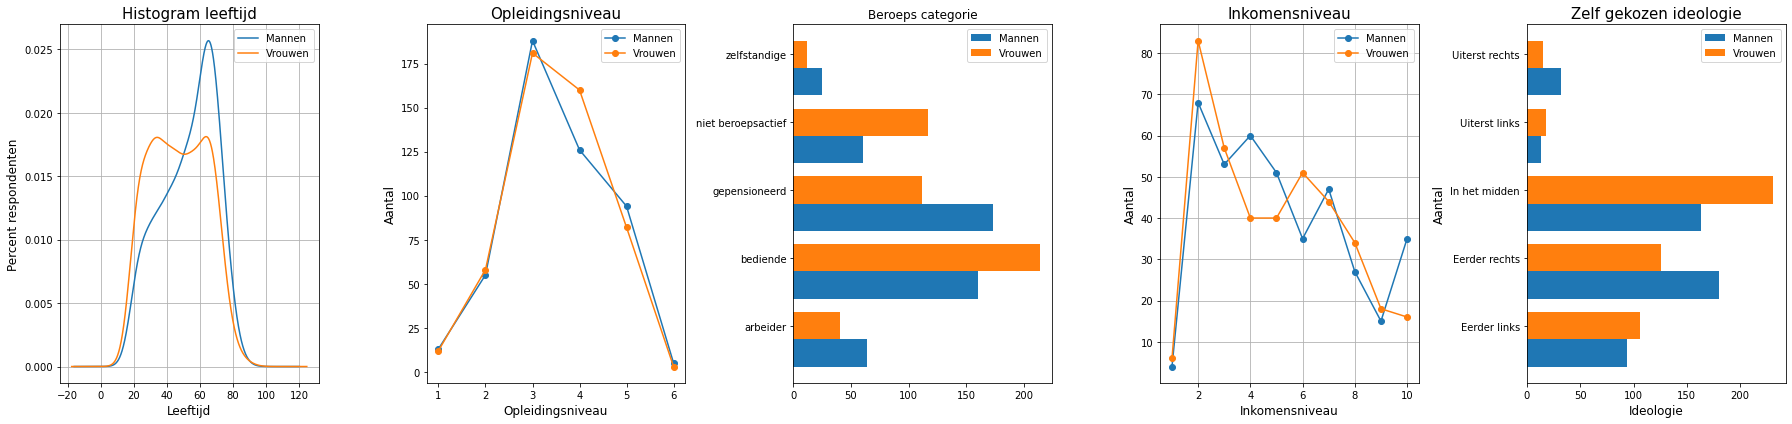

In [115]:
fig, axes = plt.subplots(1,5, figsize=(25,6))

# Leeftijd
data_cleaned.loc[data_cleaned['Geslacht']=='Man','Leeftijd'].plot.kde(bw_method=0.3, ax=axes[0], label='Mannen')
data_cleaned.loc[data_cleaned['Geslacht']=='Vrouw','Leeftijd'].plot.kde(bw_method=0.3, ax=axes[0], label='Vrouwen')
axes[0].set_ylabel('Percent respondenten', size=12)
axes[0].set_xlabel('Leeftijd', size=12)
axes[0].set_title('Histogram leeftijd',size=15)
axes[0].legend()
axes[0].grid()

# Opleiding
value_counts_opleidings_niveua = data_cleaned.groupby(['Geslacht', 'Opleiding_num'])['Provincie'].agg(len).reset_index()
value_counts_opleidings_niveua.columns = ['Geslacht', 'Opleiding_num', 'Aantal']

axes[1].plot(value_counts_opleidings_niveua.loc[value_counts_opleidings_niveua['Geslacht']=='Man','Opleiding_num'],
             value_counts_opleidings_niveua.loc[value_counts_opleidings_niveua['Geslacht']=='Man','Aantal'],
                label='Mannen', marker='o')
axes[1].plot(value_counts_opleidings_niveua.loc[value_counts_opleidings_niveua['Geslacht']=='Man','Opleiding_num'],
             value_counts_opleidings_niveua.loc[value_counts_opleidings_niveua['Geslacht']=='Vrouw','Aantal'],
                label='Vrouwen', marker='o')
axes[1].set_title('Opleidingsniveau', size=15)
axes[1].legend()
axes[1].set_xlabel('Opleidingsniveau', size=12)
axes[1].set_ylabel('Aantal', size=12)

# Beroep
value_counts_beroep = data_cleaned.groupby(['Geslacht', 'Beroep algemeen'])['Provincie'].agg(len).reset_index()
value_counts_beroep.columns = ['Geslacht', 'Beroep', 'Aantal']

axes[2].barh(width=value_counts_beroep.loc[value_counts_beroep['Geslacht']=='Man', 'Aantal'], 
            y=np.arange(len(value_counts_beroep.loc[value_counts_beroep['Geslacht']=='Man', 'Aantal']))-0.2, 
            tick_label=value_counts_beroep.loc[value_counts_beroep['Geslacht']=='Man', 'Beroep'],
            height=0.4, label='Mannen')
axes[2].barh(width=value_counts_beroep.loc[value_counts_beroep['Geslacht']=='Vrouw', 'Aantal'], 
            y=np.arange(len(value_counts_beroep.loc[value_counts_beroep['Geslacht']=='Vrouw', 'Aantal']))+0.2, 
            tick_label=value_counts_beroep.loc[value_counts_beroep['Geslacht']=='Vrouw', 'Beroep'],
            height=0.4, label='Vrouwen')
axes[2].set_title('Beroeps categorie')
axes[2].legend()

# Inkomen
value_counts_inkomen = data_cleaned.groupby(['Geslacht', 'Inkomen_num'])['Provincie'].agg(len).reset_index()
value_counts_inkomen.columns = ['Geslacht', 'Inkomen_num', 'Aantal']

axes[3].plot(value_counts_inkomen.loc[value_counts_inkomen['Geslacht']=='Man','Inkomen_num'],
             value_counts_inkomen.loc[value_counts_inkomen['Geslacht']=='Man','Aantal'],
                label='Mannen', marker='o')
axes[3].plot(value_counts_inkomen.loc[value_counts_inkomen['Geslacht']=='Man','Inkomen_num'],
             value_counts_inkomen.loc[value_counts_inkomen['Geslacht']=='Vrouw','Aantal'],
                label='Vrouwen', marker='o')
axes[3].set_title('Inkomensniveau', size=15)
axes[3].legend()
axes[3].set_xlabel('Inkomensniveau', size=12)
axes[3].set_ylabel('Aantal', size=12)
axes[3].grid()


# Opleiding
value_counts_ideologie = data_cleaned.groupby(['Geslacht', 'Q15: Ideologische zelfpositionering links/rechts'])['Provincie'].agg(len).reset_index()
value_counts_ideologie.columns = ['Geslacht', 'Ideologie', 'Aantal']

axes[4].barh(width=value_counts_ideologie.loc[value_counts_ideologie['Geslacht']=='Man', 'Aantal'], 
            y=np.arange(len(value_counts_ideologie.loc[value_counts_ideologie['Geslacht']=='Man', 'Aantal']))-0.2, 
            tick_label=value_counts_ideologie.loc[value_counts_ideologie['Geslacht']=='Man', 'Ideologie'],
            height=0.4, label='Mannen')
axes[4].barh(width=value_counts_ideologie.loc[value_counts_ideologie['Geslacht']=='Vrouw', 'Aantal'], 
            y=np.arange(len(value_counts_ideologie.loc[value_counts_ideologie['Geslacht']=='Vrouw', 'Aantal']))+0.2, 
            tick_label=value_counts_ideologie.loc[value_counts_ideologie['Geslacht']=='Vrouw', 'Ideologie'],
            height=0.4, label='Vrouwen')

axes[4].set_title('Zelf gekozen ideologie', size=15)
axes[4].legend()
axes[4].set_xlabel('Ideologie', size=12)
axes[4].set_ylabel('Aantal', size=12)



fig.tight_layout()

## Partijen instroom

In [357]:
stem_vandaag = pd.DataFrame(data_cleaned['Q7: voorkeur'].value_counts(normalize=True))*100
stem_vandaag.columns = ['Stem vandaag']

stem_2019 = pd.DataFrame(data_cleaned['Q10: stem 2019'].value_counts(normalize=True))*100
stem_2019.columns = ['Stem 2019']
stem_2019 = stem_2019.rename(index={'sp.a (nu Vooruit)':'Vooruit'})


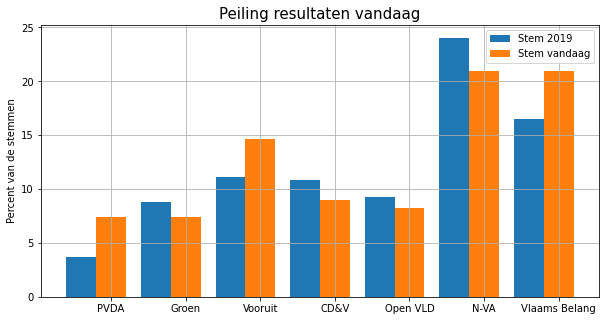

In [362]:
peiling_vandaag = pd.merge(stem_2019, stem_vandaag, left_index=True, right_index=True, how='outer')

peiling_vandaag = peiling_vandaag.loc[['PVDA', 'Groen', 'Vooruit', 'CD&V', 'Open VLD','N-VA', 'Vlaams Belang']]

fig, ax = plt.subplots(1,1,figsize=(10,5))

ax.bar(height=peiling_vandaag['Stem 2019'], tick_label=peiling_vandaag.index, x=np.arange(len(peiling_vandaag))-0.2, width=0.4, label='Stem 2019')
ax.bar(height=peiling_vandaag['Stem vandaag'], tick_label=peiling_vandaag.index, x=np.arange(len(peiling_vandaag))+0.2, width=0.4, label='Stem vandaag')
ax.legend()
ax.set_title('Peiling resultaten vandaag', size=15)
ax.set_ylabel('Percent van de stemmen')
ax.grid()

In [355]:
np.arange(len(peiling_vandaag))-0.5

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5])

In [349]:
#peiling_vandaag['ging niet stemmen']

<AxesSubplot:xlabel='Q7: voorkeur', ylabel='Q10: stem 2019'>

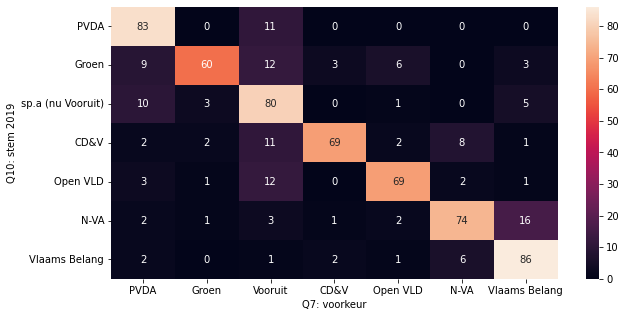

In [332]:
partijen_instroom = pd.crosstab(columns=data_cleaned['Q7: voorkeur'], 
                                index=data_cleaned['Q10: stem 2019'], 
                                margins=False,normalize='index'  )*100
partijen_instroom = partijen_instroom.round()
#'andere partij', 'ging niet stemmen', 'mocht nog niet stemmen',
#        'stemde blanco-ongeldig', 'weet niet',
#       'weiger te antwoorden'
#, 
 #      'andere partij', 'ga niet stemmen', 'stem blanco-ongeldig', 'weet niet',  'weiger te antwoorden'
partijen_instroom = partijen_instroom.loc[[ 'PVDA','Groen','sp.a (nu Vooruit)', 'CD&V','Open VLD','N-VA',   'Vlaams Belang'],
                ['PVDA', 'Groen','Vooruit','CD&V',  'Open VLD','N-VA', 'Vlaams Belang']]

fig, ax = plt.subplots(1,1, figsize=(10, 5))
sb.heatmap(partijen_instroom, annot=True)


<AxesSubplot:xlabel='Q10: stem 2019', ylabel='Q7: voorkeur'>

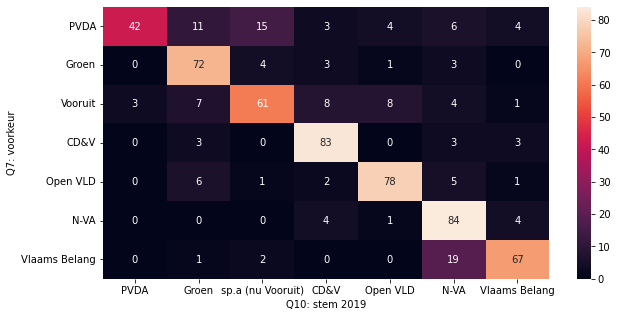

In [334]:
partijen_instroom = pd.crosstab(columns=data_cleaned['Q7: voorkeur'], 
                                index=data_cleaned['Q10: stem 2019'], 
                                margins=False,normalize='columns'  )*100
partijen_instroom = partijen_instroom.round()
#'andere partij', 'ging niet stemmen', 'mocht nog niet stemmen',
#        'stemde blanco-ongeldig', 'weet niet',
#       'weiger te antwoorden'
#, 
 #      'andere partij', 'ga niet stemmen', 'stem blanco-ongeldig', 'weet niet',  'weiger te antwoorden'
partijen_instroom = partijen_instroom.loc[[ 'PVDA','Groen','sp.a (nu Vooruit)', 'CD&V','Open VLD','N-VA',   'Vlaams Belang'],
                ['PVDA', 'Groen','Vooruit','CD&V',  'Open VLD','N-VA', 'Vlaams Belang']]

partijen_instroom = partijen_instroom.transpose()

fig, ax = plt.subplots(1,1, figsize=(10, 5))
sb.heatmap(partijen_instroom, annot=True)

In [337]:
#partijen_instroom.sum(axis=1)

## 1. Potentieel van de partijen

Text(0.5, 1.0, 'Aantal potieel Ja')

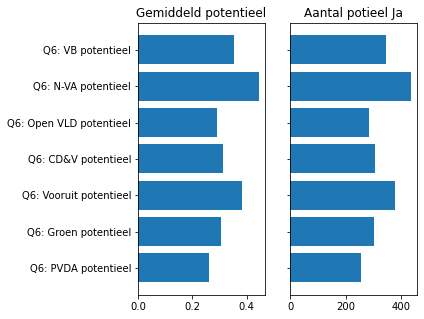

In [13]:
potentieel_per_partij = data_cleaned[kolommen_potienteel_partijen].agg(lambda x: np.mean(x==1))
stemmen_per_partij = data_cleaned[kolommen_potienteel_partijen].agg(lambda x: np.sum(x>0))

fig, axes = plt.subplots(1,2, figsize=(5,5), sharey=True)

axes[0].barh(width=potentieel_per_partij, y=np.arange(len(potentieel_per_partij)), tick_label=potentieel_per_partij.index)
axes[0].set_title('Gemiddeld potentieel')

axes[1].barh(width=stemmen_per_partij, y=np.arange(len(stemmen_per_partij)), tick_label=stemmen_per_partij.index)
axes[1].set_title('Aantal potieel Ja')


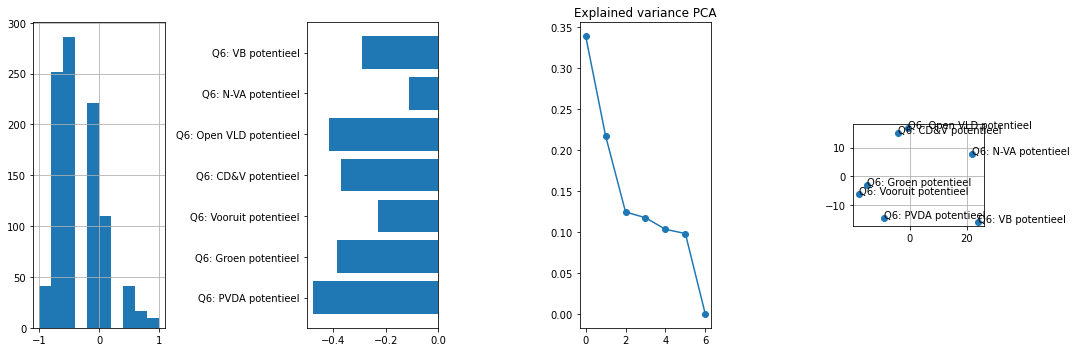

In [14]:
stem_potentieel = data_cleaned[kolommen_potienteel_partijen].copy()
gemiddeld_potentieel_per_partij = data_cleaned[kolommen_potienteel_partijen].mean()
stem_potentieel_demeaned = stem_potentieel - gemiddeld_potentieel_per_partij
from sklearn.decomposition import PCA

pca = PCA()
potentieel_pca_components = pca.fit_transform(np.transpose(stem_potentieel_demeaned))
potentieel_pca_components = pd.DataFrame(potentieel_pca_components, index=stem_potentieel_demeaned.columns).loc[:,:1]
potentieel_pca_components.columns=['pca_1', 'pca_2']

fig, axes = plt.subplots(1,4, figsize=(15,5))
    
data_cleaned[kolommen_potienteel_partijen].mean(axis=1).hist(ax=axes[0])    
axes[0]

axes[1].barh(tick_label=gemiddeld_potentieel_per_partij.index, width=gemiddeld_potentieel_per_partij, y=np.arange(len(gemiddeld_potentieel_per_partij)))

axes[2].plot(pca.explained_variance_ratio_, marker='o')
axes[2].set_title('Explained variance PCA')

axes[3].scatter(potentieel_pca_components['pca_1'], potentieel_pca_components['pca_2'])
for partij in potentieel_pca_components.index:
    axes[3].text(x=potentieel_pca_components.loc[partij, 'pca_1'],
                 y=potentieel_pca_components.loc[partij, 'pca_2'],
                 s=partij)
axes[3].set_aspect('equal')
axes[3].grid()

fig.tight_layout()

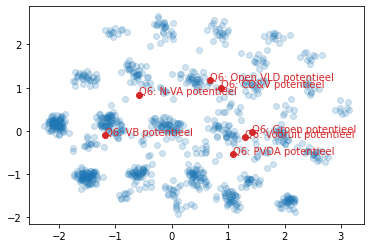

In [15]:
pca = PCA(n_components=2)
potentieel_pca_components = pca.fit_transform(stem_potentieel_demeaned)
potentieel_pca_components = pd.DataFrame(potentieel_pca_components)
potentieel_pca_components.columns=['pca_1', 'pca_2']

fig, ax = plt.subplots(1,1)

ax.scatter(potentieel_pca_components['pca_1']+np.random.randn(len(potentieel_pca_components))/10, 
           potentieel_pca_components['pca_2']+np.random.randn(len(potentieel_pca_components))/10, alpha=0.2)
for column in stem_potentieel_demeaned.columns:
    row_mask = data_cleaned[column]==1
    ax.scatter(potentieel_pca_components.loc[row_mask.values,'pca_1'].mean(),
               potentieel_pca_components.loc[row_mask.values,'pca_2'].mean(),
               c='C3')
    ax.text(potentieel_pca_components.loc[row_mask.values,'pca_1'].mean(),
               potentieel_pca_components.loc[row_mask.values,'pca_2'].mean(),
            s=column,
               c='C3')    

Text(0.5, 1.0, 'Correlatie matrix potentieel partijen')

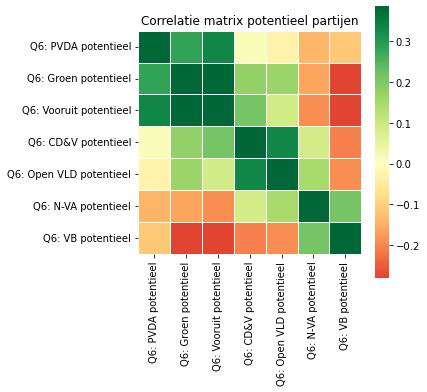

In [16]:
# Compute the correlation matrix
corr = data_cleaned[kolommen_potienteel_partijen].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5,5 ))

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corr, square=True, linewidths=.5,center=0,vmin=corr.min().min(), vmax=corr.replace(1, 0).max().max(), cmap='RdYlGn', ax=ax)

ax.set_title('Correlatie matrix potentieel partijen')

<AxesSubplot:xlabel='partij_1', ylabel='partij_2'>

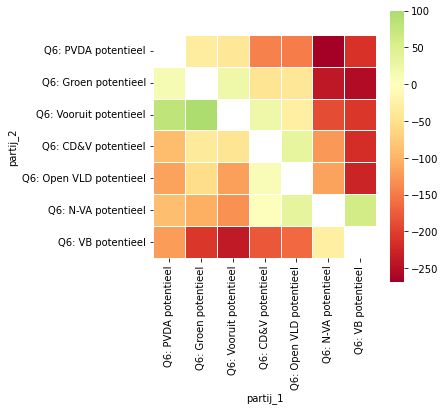

In [17]:
partij_pair_counts = []
for i, partij_1 in enumerate(kolommen_potienteel_partijen):
    for j, partij_2 in enumerate(kolommen_potienteel_partijen):
        if(partij_1==partij_2):continue
        partij_pair_counts.append({'partij_1':partij_1, 
                                   'partij_2':partij_2, 
                                   'counts':data_cleaned.loc[data_cleaned[partij_1]==1,partij_2].sum()})
partij_pair_counts = pd.DataFrame(partij_pair_counts)
partij_pair_counts_pivot = pd.pivot(columns ='partij_1', index='partij_2', values='counts', data=partij_pair_counts)
partij_pair_counts_pivot = partij_pair_counts_pivot.loc[kolommen_potienteel_partijen, kolommen_potienteel_partijen]

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5,5 ))

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(partij_pair_counts_pivot, square=True, linewidths=.5,center=0, cmap='RdYlGn', ax=ax)


In [302]:
potentieel_per_partij = []
for i, partij in enumerate(np.unique(data_cleaned['Partij_vandaag'])):
    subset = data_cleaned.loc[data_cleaned['Partij_vandaag']==partij,:]
    
    for j, potentiele_partij in enumerate(kolommen_potienteel_partijen):
        
        if(partij==potentiele_partij): continue
            
        potentieel_per_partij.append({'partij_vandaag':partij,
                                         'potentiele_partij':potentiele_partij,
                                         'potentieel':np.mean(subset[potentiele_partij]==1)})
        
potentieel_per_partij = pd.DataFrame(potentieel_per_partij)
potentieel_per_partij = pd.pivot(columns='potentiele_partij', index='partij_vandaag', values='potentieel', data=potentieel_per_partij)

potentieel_per_partij = potentieel_per_partij.loc[:,kolommen_potienteel_partijen]
potentieel_per_partij.columns = [re.sub('Q6: ','',c) for c in potentieel_per_partij.columns]
potentieel_per_partij = potentieel_per_partij.replace(1,0)
#potentieel_per_partij

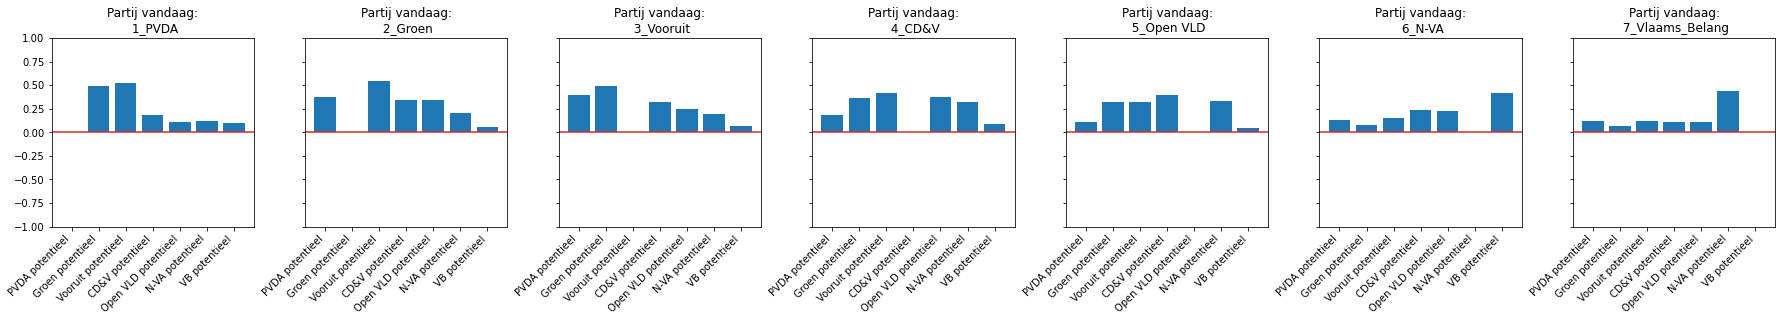

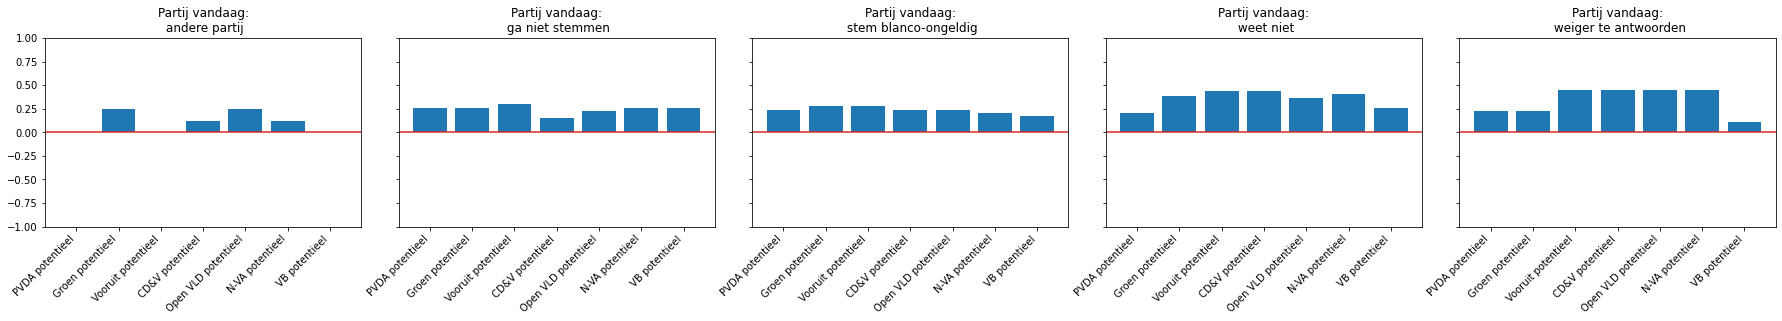

In [19]:
klassieke_partijen = ['1_PVDA','2_Groen','3_Vooruit','4_CD&V','5_Open VLD','6_N-VA','7_Vlaams_Belang' ]
fig, axes = plt.subplots(1, len(klassieke_partijen), figsize=(25,4), sharex=True, sharey=True)

for i, partij_vandaag in enumerate(klassieke_partijen):
    
    axes[i].bar(height=potentieel_per_partij.loc[partij_vandaag], 
                x=np.arange(len(potentieel_per_partij.loc[partij_vandaag])),
                tick_label=potentieel_per_partij.loc[partij_vandaag].index)
    axes[i].set_ylim(-1,1)
    axes[i].axhline(0, c='C3')
    axes[i].set_title(f'Partij vandaag:\n {partij_vandaag}')
            
fig.tight_layout()
fig.autofmt_xdate(rotation=45)
   
blancos = ['andere partij', 'ga niet stemmen', 'stem blanco-ongeldig', 'weet niet', 'weiger te antwoorden']    
fig, axes = plt.subplots(1, len(blancos), figsize=(25,4), sharex=True, sharey=True)
for i, partij_vandaag in enumerate(blancos):
    
    axes[i].bar(height=potentieel_per_partij.loc[partij_vandaag], 
                x=np.arange(len(potentieel_per_partij.loc[partij_vandaag])),
                tick_label=potentieel_per_partij.loc[partij_vandaag].index)
    axes[i].set_ylim(-1,1)
    axes[i].axhline(0, c='C3')
    axes[i].set_title(f'Partij vandaag:\n {partij_vandaag}')
            
fig.tight_layout()
fig.autofmt_xdate(rotation=45)
    

## 2 PCA: kolommen met vragen met scores 0-7

In [20]:
question_map = {
    'Q66: Vertrouwen 1':'Q66: Vertrouwen 1', 
    'Q67: Vertrouwen 2':'Q67: Vertrouwen 2', 
    'Q68: Vertrouwen 3':'Q68: Vertrouwen 3',
    'Q44: Ongelijkheid 1':'Lot van mensen zelf in de hand', 
    'Q45: Ongelijkheid 2':'Overheid niet nodig voor welzijn mensen', 
    'Q46: Ongelijkheid 3':'Inkomensongelijkheid is te klein',
    'Q47: Klimaat 1':'Technologie volstaat niet voor klimaat, Gedragswijziging nodig',
    'Q48: Klimaat 2':'Klimaatcrisis wordt overdreven', 
    'Q49: Klimaat 3':'Inkomen afstaan voor klimaat', 
    'Q50: Migratie 1':'Migranten minder rechten dan Belgen',
    'Q51: Migratie 2':'Migranten moeten aanpassen aan de Europese cultuur', 
    'Q52: Migratie 3':'We moeten meer vluchtelingen opvangen',
    'Q53: Verzorgingsstaat/Overheid 1':'Overheid moet ondernemingen reguleren', 
    'Q54: Verzorgingsstaat/Overheid 2':'We moeten de verzorgingstaat afbouwen',
    'Q55: Vlaanderen / België': 'België moet alles beslissen, niet regionaliseren', 
    'Q56: Veiligheid':'Mildere politie en justitie', 
    'Q57: Bewust 1': 'Discriminatie geen probleem, minderheden hebben gelijke kansen',
    'Q58: Bewust 2': 'Genderneutrale woorden in scholen',
    'Q59: Bewust 3': 'De slinger van #MeToo is doorgeslagen',
    'Q60: Houding tav politiek / democratie 1':'Tevreden democratie in Belgie',
    'Q61: Houding tav politiek / democratie 2':'Politici algemeen belang, geen eigenbelang',
    'Q62: Houding tav politiek / democratie 3':'Geen enkele partij geeft om mensen zoals ik',
}

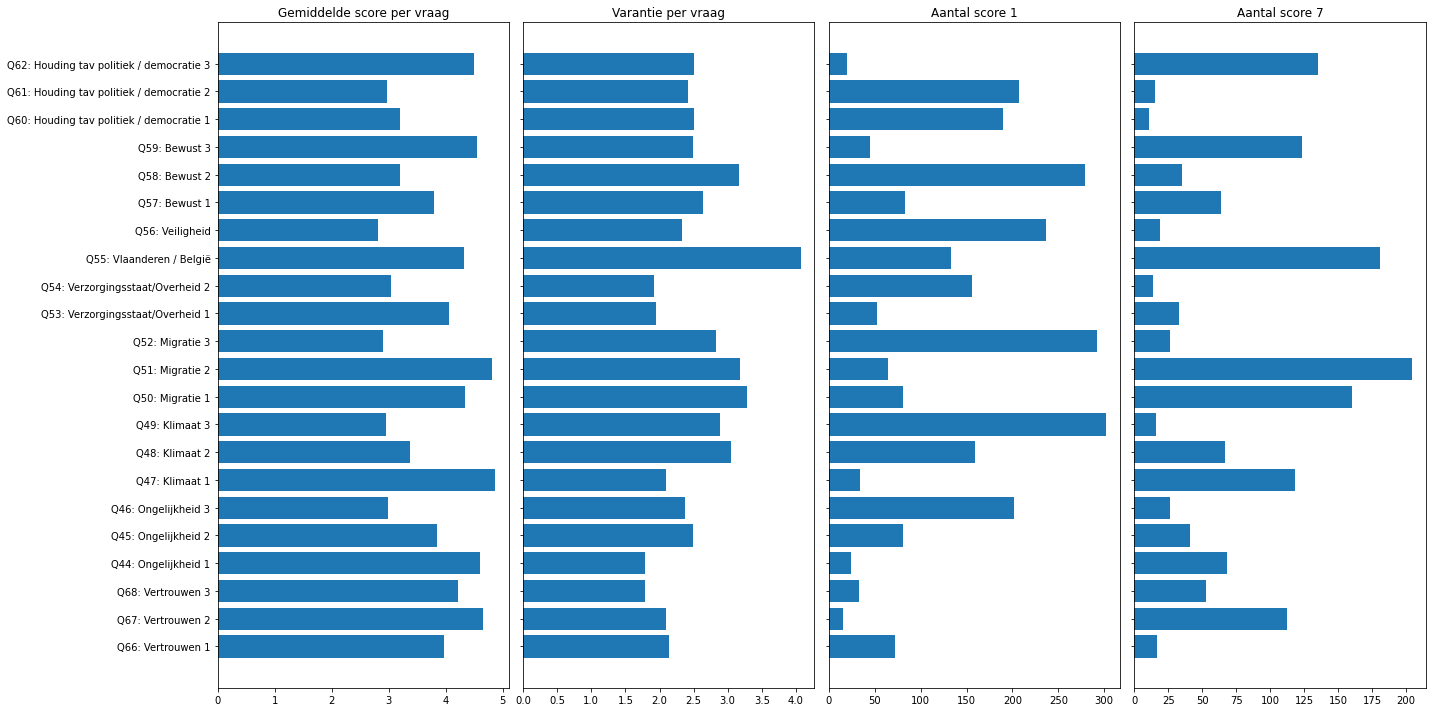

In [21]:
aggregate_numbers = pd.DataFrame({'mean':data_cleaned[columns_with_0_to_7_score].mean().values,
              'var':data_cleaned[columns_with_0_to_7_score].var().values,
              'x_score_1': np.sum(data_cleaned[columns_with_0_to_7_score]==1),
              'x_score_7': np.sum(data_cleaned[columns_with_0_to_7_score]==7)})

fig, axes = plt.subplots(1,4, figsize=(20,10), sharey=True)

axes[0].barh(tick_label=aggregate_numbers.index, width=aggregate_numbers['mean'], y=np.arange(len(aggregate_numbers)))
axes[0].set_title('Gemiddelde score per vraag')

axes[1].barh(tick_label=aggregate_numbers.index, width=aggregate_numbers['var'], y=np.arange(len(aggregate_numbers)))
axes[1].set_title('Varantie per vraag')

axes[2].barh(tick_label=aggregate_numbers.index, width=aggregate_numbers['x_score_1'], y=np.arange(len(aggregate_numbers)))
axes[2].set_title('Aantal score 1')

axes[3].barh(tick_label=aggregate_numbers.index, width=aggregate_numbers['x_score_7'], y=np.arange(len(aggregate_numbers)))
axes[3].set_title('Aantal score 7')

fig.tight_layout()

<AxesSubplot:>

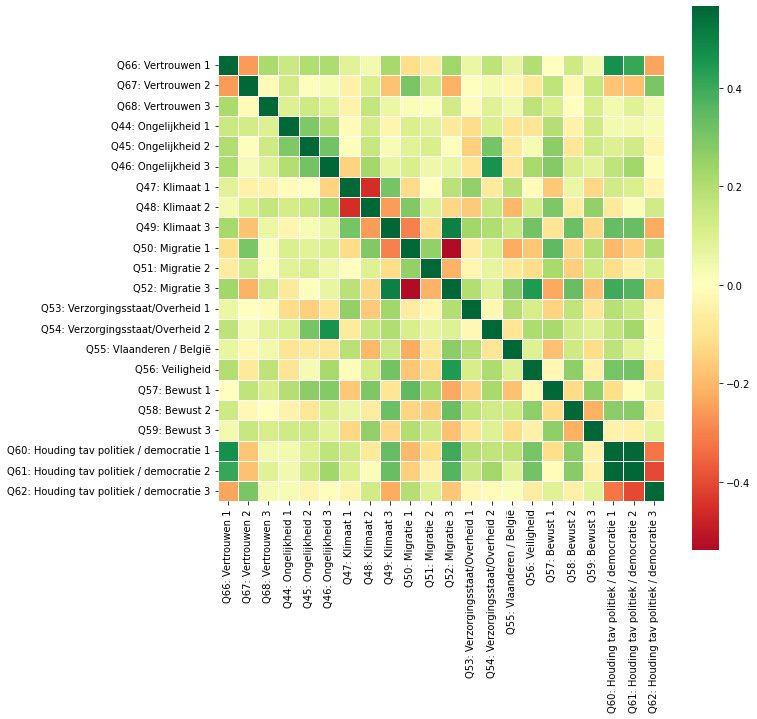

In [117]:
# Compute the correlation matrix
corr = data_cleaned[columns_with_0_to_7_score].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,10 ))

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corr, square=True, linewidths=.5,center=0,vmin=corr.min().min(), vmax=corr.replace(1, 0).max().max(), cmap='RdYlGn', ax=ax)

In [255]:
[c for c in data_cleaned.columns if re.search('pca', c)]

['pca_1', 'pca_2', 'pca_3']

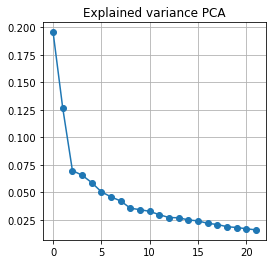

In [236]:
from sklearn.decomposition import PCA

pca = PCA()
pca_components_respondents = pca.fit_transform(data_cleaned[columns_with_0_to_7_score])
pca_components_respondents = pd.DataFrame(pca_components_respondents).loc[:,:2]
pca_components_respondents.index = data_cleaned.index
pca_components_respondents.columns=['pca_1', 'pca_2', 'pca_3']

data_cleaned = data_cleaned.drop(columns=['pca_1', 'pca_2','pca_3'], errors='ignore' )
data_cleaned = pd.merge(data_cleaned, pca_components_respondents, left_index=True, right_index=True, how='left')

fig, ax = plt.subplots(1,1, figsize=(4,4))

ax.plot(pca.explained_variance_ratio_, marker='o')
ax.set_title('Explained variance PCA')
ax.grid()

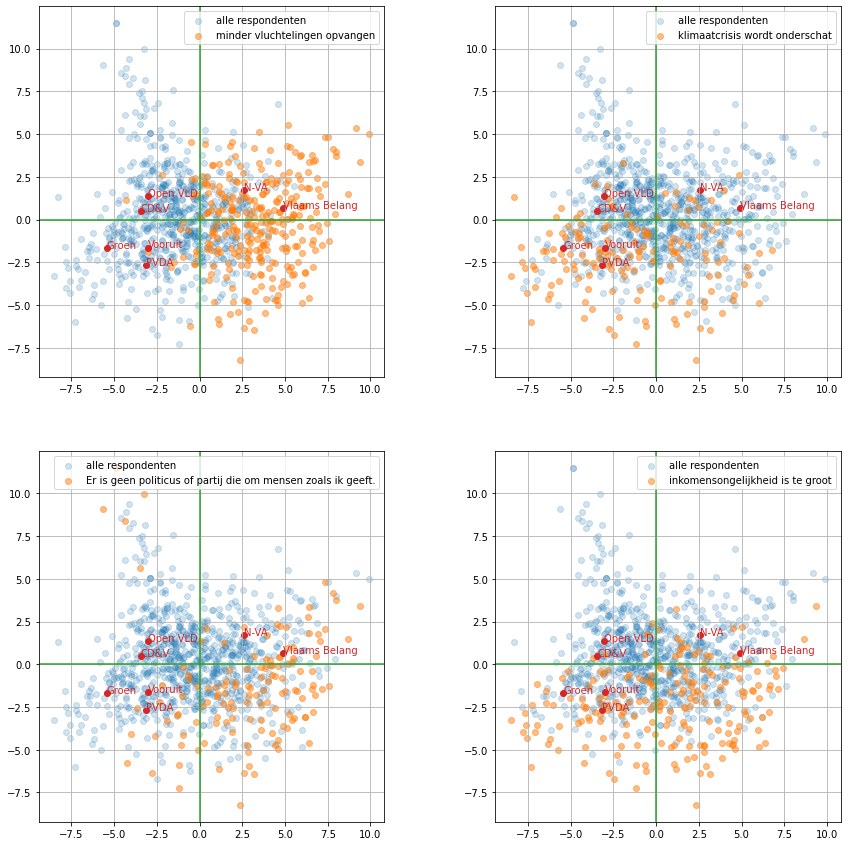

In [237]:
scaling_factor_partijen=2

fig, axes = plt.subplots(2,2, figsize=(15,15))

# Plot 1: minder vluchtelingen
row_mask = (data_cleaned['Q52: Migratie 3']==1)
axes[0][0].scatter(pca_components_respondents.loc[~row_mask.values,'pca_1'], 
                pca_components_respondents.loc[~row_mask.values,'pca_2'], alpha=0.2, label="alle respondenten")
axes[0][0].scatter(pca_components_respondents.loc[row_mask.values,'pca_1'],
           pca_components_respondents.loc[row_mask.values,'pca_2'], c='C1', alpha=0.5, label="minder vluchtelingen opvangen")

for partij_vandaag in np.unique(data_cleaned['Q7: voorkeur']):
    if not partij_vandaag in ['PVDA', 'Groen', 'Vooruit', 'CD&V', 'Open VLD', 'N-VA', 'Vlaams Belang']: continue
    
    row_mask = data_cleaned['Q7: voorkeur']==partij_vandaag
    axes[0][0].scatter(pca_components_respondents.loc[row_mask.values,'pca_1'].mean()*scaling_factor_partijen,
               pca_components_respondents.loc[row_mask.values,'pca_2'].mean()*scaling_factor_partijen,
               c='C3')
    axes[0][0].text(pca_components_respondents.loc[row_mask.values,'pca_1'].mean()*scaling_factor_partijen,
               pca_components_respondents.loc[row_mask.values,'pca_2'].mean()*scaling_factor_partijen,
            s=partij_vandaag,
               c='C3') 
    
axes[0][0].grid()
axes[0][0].axvline(0, c='C2')
axes[0][0].axhline(0, c='C2')
axes[0][0].legend()
axes[0][0].set_aspect('equal')

# Plot 2: klimaat onderschat
row_mask = (data_cleaned['Q48: Klimaat 2']==1)
axes[0][1].scatter(pca_components_respondents.loc[~row_mask.values,'pca_1'], 
                pca_components_respondents.loc[~row_mask.values,'pca_2'], alpha=0.2, label="alle respondenten")
axes[0][1].scatter(pca_components_respondents.loc[row_mask.values,'pca_1'],
           pca_components_respondents.loc[row_mask.values,'pca_2'], c='C1', alpha=0.5, label='klimaatcrisis wordt onderschat')

for partij_vandaag in np.unique(data_cleaned['Q7: voorkeur']):
    if not partij_vandaag in ['PVDA', 'Groen', 'Vooruit', 'CD&V', 'Open VLD', 'N-VA', 'Vlaams Belang']: continue
    
    row_mask = data_cleaned['Q7: voorkeur']==partij_vandaag
    axes[0][1].scatter(pca_components_respondents.loc[row_mask.values,'pca_1'].mean()*scaling_factor_partijen,
               pca_components_respondents.loc[row_mask.values,'pca_2'].mean()*scaling_factor_partijen,
               c='C3')
    axes[0][1].text(pca_components_respondents.loc[row_mask.values,'pca_1'].mean()*scaling_factor_partijen,
               pca_components_respondents.loc[row_mask.values,'pca_2'].mean()*scaling_factor_partijen,
            s=partij_vandaag,
               c='C3') 
    
axes[0][1].grid()
axes[0][1].axvline(0, c='C2')
axes[0][1].axhline(0, c='C2')
axes[0][1].legend()
axes[0][1].set_aspect('equal')    
    
# Plot 3: 'Er is geen enkele politicus of politieke partij die om mij of om mensen zoals ik geeft.'
row_mask = (data_cleaned['Q62: Houding tav politiek / democratie 3']==7)
axes[1][0].scatter(pca_components_respondents.loc[~row_mask.values,'pca_1'], 
                pca_components_respondents.loc[~row_mask.values,'pca_2'], alpha=0.2, label="alle respondenten")
axes[1][0].scatter(pca_components_respondents.loc[row_mask.values,'pca_1'],
           pca_components_respondents.loc[row_mask.values,'pca_2'], c='C1', alpha=0.5, label='Er is geen politicus of partij die om mensen zoals ik geeft.')

for partij_vandaag in np.unique(data_cleaned['Q7: voorkeur']):
    if not partij_vandaag in ['PVDA', 'Groen', 'Vooruit', 'CD&V', 'Open VLD', 'N-VA', 'Vlaams Belang']: continue
    
    row_mask = data_cleaned['Q7: voorkeur']==partij_vandaag
    axes[1][0].scatter(pca_components_respondents.loc[row_mask.values,'pca_1'].mean()*scaling_factor_partijen,
               pca_components_respondents.loc[row_mask.values,'pca_2'].mean()*scaling_factor_partijen,
               c='C3')
    axes[1][0].text(pca_components_respondents.loc[row_mask.values,'pca_1'].mean()*scaling_factor_partijen,
               pca_components_respondents.loc[row_mask.values,'pca_2'].mean()*scaling_factor_partijen,
            s=partij_vandaag,
               c='C3') 
    
axes[1][0].grid()
axes[1][0].axvline(0, c='C2')
axes[1][0].axhline(0, c='C2')
axes[1][0].legend()
axes[1][0].set_aspect('equal')

# Plot 4: "GEEN genderneutrale voornaamwoorden aanleren zoals die en hun in scholen"
row_mask = (data_cleaned['Q46: Ongelijkheid 3']==1)
axes[1][1].scatter(pca_components_respondents.loc[~row_mask.values,'pca_1'], 
                pca_components_respondents.loc[~row_mask.values,'pca_2'], alpha=0.2, label="alle respondenten")
axes[1][1].scatter(pca_components_respondents.loc[row_mask.values,'pca_1'],
           pca_components_respondents.loc[row_mask.values,'pca_2'], c='C1', alpha=0.5, label="inkomensongelijkheid is te groot")

for partij_vandaag in np.unique(data_cleaned['Q7: voorkeur']):
    if not partij_vandaag in ['PVDA', 'Groen', 'Vooruit', 'CD&V', 'Open VLD', 'N-VA', 'Vlaams Belang']: continue
    
    row_mask = data_cleaned['Q7: voorkeur']==partij_vandaag
    axes[1][1].scatter(pca_components_respondents.loc[row_mask.values,'pca_1'].mean()*scaling_factor_partijen,
               pca_components_respondents.loc[row_mask.values,'pca_2'].mean()*scaling_factor_partijen,
               c='C3')
    axes[1][1].text(pca_components_respondents.loc[row_mask.values,'pca_1'].mean()*scaling_factor_partijen,
               pca_components_respondents.loc[row_mask.values,'pca_2'].mean()*scaling_factor_partijen,
            s=partij_vandaag,
               c='C3') 
    
axes[1][1].grid()
axes[1][1].axvline(0, c='C2')
axes[1][1].axhline(0, c='C2')
axes[1][1].legend()
axes[1][1].set_aspect('equal')



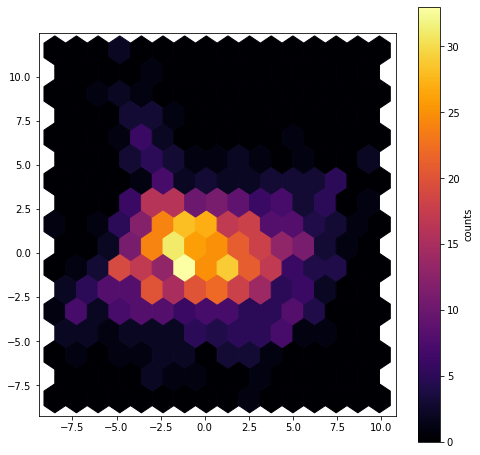

In [238]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

hb = ax.hexbin(pca_components_respondents['pca_1'], pca_components_respondents['pca_2'], gridsize=15, cmap='inferno')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')
ax.set_aspect('equal')

In [301]:
def demographics_plot(partij):
    
    subset = data_cleaned.loc[data_cleaned['Q7: voorkeur']==partij,:].copy()
    
    fig, axes = plt.subplots(1,6, figsize=(25,6))

    # Leeftijd
    subset['Leeftijd'].plot.kde(bw_method=0.3, ax=axes[0], label=f'kiezers {partij}')
    data_cleaned['Leeftijd'].plot.kde(bw_method=0.3, ax=axes[0], label=f'alle respondenten')
    axes[0].set_ylabel('Percent respondenten', size=12)
    axes[0].set_xlabel('Leeftijd', size=12)
    axes[0].set_title('Histogram leeftijd',size=15)
    axes[0].legend()
    axes[0].grid()

    # Opleiding
    value_counts_opleidings_niveua_subset = pd.DataFrame(subset['Opleiding_num'].value_counts(normalize=True)).reset_index()
    value_counts_opleidings_niveua_subset.columns=['Opleiding_num', 'Aantal subset']
    value_counts_opleidings_niveua_algemeen = pd.DataFrame(data_cleaned['Opleiding_num'].value_counts(normalize=True)).reset_index()
    value_counts_opleidings_niveua_algemeen.columns=['Opleiding_num', 'Aantal algemeen']
    value_counts_opleidings_niveua = pd.merge(value_counts_opleidings_niveua_subset, value_counts_opleidings_niveua_algemeen, how='outer').fillna(0)
    value_counts_opleidings_niveua = value_counts_opleidings_niveua.sort_values('Opleiding_num')

    axes[1].plot(value_counts_opleidings_niveua['Opleiding_num'],
        value_counts_opleidings_niveua['Aantal subset'],
                    label=f'kiezers {partij}', marker='o')
    axes[1].plot(value_counts_opleidings_niveua['Opleiding_num'],
        value_counts_opleidings_niveua['Aantal algemeen'],
                    label=f'alle respondenten', marker='o')
    axes[1].set_title('Opleidingsniveau', size=15)
    axes[1].legend()
    axes[1].set_xlabel('Opleidingsniveau', size=12)
    axes[1].set_ylabel('Aantal', size=12)

    # Beroep
    value_counts_beroep_subset = pd.DataFrame(subset['Beroep algemeen'].value_counts(normalize=True)).reset_index()
    value_counts_beroep_subset.columns=['Beroep', 'Aantal_subset']
    value_counts_beroep_algemeen = pd.DataFrame(data_cleaned['Beroep algemeen'].value_counts(normalize=True)).reset_index()
    value_counts_beroep_algemeen.columns=['Beroep', 'Aantal_algemeen']
    value_counts_beroep = pd.merge(value_counts_beroep_algemeen, value_counts_beroep_subset, how='outer').fillna(0)
    value_counts_beroep = value_counts_beroep.sort_values('Beroep')

    axes[2].barh(width=value_counts_beroep['Aantal_subset'], 
                y=np.arange(len(value_counts_beroep))-0.2, 
                tick_label=value_counts_beroep['Beroep'],
                height=0.4, label=f'kiezers {partij}')
    axes[2].barh(width=value_counts_beroep['Aantal_algemeen'], 
                y=np.arange(len(value_counts_beroep))+0.2, 
                tick_label=value_counts_beroep['Beroep'],
                height=0.4, label='Alle respondenten')
    axes[2].set_title('Beroeps categorie', size=15)
    axes[2].legend()

    # Inkomen
    value_counts_inkomen_subset = pd.DataFrame(subset['Inkomen_num'].value_counts(normalize=True)).reset_index()
    value_counts_inkomen_subset.columns=['Inkomen_num', 'Aantal_subset']
    value_counts_inkomen_algemeen = pd.DataFrame(data_cleaned['Inkomen_num'].value_counts(normalize=True)).reset_index()
    value_counts_inkomen_algemeen.columns=['Inkomen_num', 'Aantal_algemeen']
    value_counts_inkomen = pd.merge(value_counts_inkomen_subset, value_counts_inkomen_algemeen, how='outer').fillna(0)
    value_counts_inkomen = value_counts_inkomen.sort_values('Inkomen_num')

    axes[3].plot(value_counts_inkomen['Inkomen_num'],
                 value_counts_inkomen['Aantal_subset'],
                    label=f'kiezers {partij}', marker='o')
    axes[3].plot(value_counts_inkomen['Inkomen_num'],
                 value_counts_inkomen['Aantal_algemeen'],
                    label='Alle respondenten', marker='o')
    axes[3].set_title('Inkomensniveau', size=15)
    axes[3].legend()
    axes[3].set_xlabel('Inkomensniveau', size=12)
    axes[3].set_ylabel('Aantal', size=12)
    axes[3].grid() 

    # Ideologie
    value_counts_ideologie_subset = pd.DataFrame(subset['Q15: Ideologische zelfpositionering links/rechts'].value_counts(normalize=True)).reset_index()
    value_counts_ideologie_subset.columns=['Ideologie', 'Aantal_subset']
    value_counts_ideologie_algemeen = pd.DataFrame(data_cleaned['Q15: Ideologische zelfpositionering links/rechts'].value_counts(normalize=True)).reset_index()
    value_counts_ideologie_algemeen.columns=['Ideologie', 'Aantal_algemeen']
    value_counts_ideologie = pd.merge(value_counts_ideologie_subset, value_counts_ideologie_algemeen, how='outer').fillna(0)
    value_counts_ideologie = value_counts_ideologie.set_index('Ideologie')
    value_counts_ideologie = value_counts_ideologie.loc[['Uiterst links', 'Eerder links', 'In het midden','Eerder rechts' ,'Uiterst rechts'],:]
    value_counts_ideologie = value_counts_ideologie.reset_index()

    axes[4].barh(width=value_counts_ideologie['Aantal_subset'], 
                y=np.arange(len(value_counts_ideologie))-0.2, 
                tick_label=value_counts_ideologie['Ideologie'],
                height=0.4, label=f'kiezers {partij}')
    axes[4].barh(width=value_counts_ideologie['Aantal_algemeen'], 
                y=np.arange(len(value_counts_ideologie))+0.2, 
                tick_label=value_counts_ideologie['Ideologie'],
                height=0.4, label='Alle respondenten')
    axes[4].set_title('Ideologie', size=15)
    axes[4].legend()
    
    # PCA
    axes[5].scatter(data_cleaned['pca_1'], data_cleaned['pca_2'], alpha=0.2)
    axes[5].scatter(subset['pca_1'].mean()*scaling_factor_partijen, subset['pca_2'].mean()*scaling_factor_partijen, c='C3')
    axes[5].text(subset['pca_1'].mean()*scaling_factor_partijen, subset['pca_2'].mean()*scaling_factor_partijen,s=partij,  c='C3')
    axes[5].axvline(0, c='black', linestyle=':')
    axes[5].axhline(0, c='black', linestyle=':')    
    axes[5].set_aspect('equal')
    axes[5].set_title('PCA components')
    
    fig.tight_layout()
    
    return None
    
    
widgets.interact(demographics_plot, partij=np.unique(data_cleaned['Q7: voorkeur']))


interactive(children=(Dropdown(description='partij', options=('CD&V', 'Groen', 'N-VA', 'Open VLD', 'PVDA', 'Vl…

<function __main__.demographics_plot(partij)>

## Belangrijkste vragen per partij

In [240]:
scores_vragen_per_partij = data_cleaned.groupby('Q7: voorkeur')[columns_with_0_to_7_score].mean() - aggregate_numbers['mean']
scores_vragen_per_partij = scores_vragen_per_partij
scores_vragen_per_partij = scores_vragen_per_partij.transpose()
scores_vragen_per_partij.index = scores_vragen_per_partij.index.map(question_map)

In [407]:
for partij in ['PVDA', 'Groen', 'Vooruit', 'CD&V', 'Open VLD', 'N-VA', 'Vlaams Belang']:
    subset = data_cleaned.loc[(data_cleaned['Q7: voorkeur']==partij),:]
    themas_list_lists = [themas.split(',') for themas in subset['Q21: Belang thema’s']]
    themas = [thema for themas in themas_list_lists for thema in themas]
    belangrijkste_themas = pd.Series(themas).value_counts().index[:2].values
    print(f'{partij}')
    print('--------')
    print(f"Belangrijkste themas: {', '.join(belangrijkste_themas)}")
    print('--------')
    print(f'Sterk tegenstander van:')
    print('...........')
    print(',\n'.join(list(scores_vragen_per_partij[partij].sort_values().head(3).index)))
    print('...........')  
    #print(scores_vragen_per_partij[partij].sort_values().tail(3).index)
    print(f'Sterk voorstander van:')
    print('...........')
    print(',\n'.join(list(scores_vragen_per_partij[partij].sort_values(ascending=False).head(3).index)))
    print('\n\n')

# Todo: ook voor potentieel
# Potentieel overtuigen is misschien anders dan de huidige kiezers

PVDA
--------
Belangrijkste themas: Gezondheidszorg, Sociale zekerheid
--------
Sterk tegenstander van:
...........
Migranten minder rechten dan Belgen,
Lot van mensen zelf in de hand,
Discriminatie geen probleem, minderheden hebben gelijke kansen
...........
Sterk voorstander van:
...........
We moeten meer vluchtelingen opvangen,
België moet alles beslissen, niet regionaliseren,
Genderneutrale woorden in scholen



Groen
--------
Belangrijkste themas: Klimaat, Milieu
--------
Sterk tegenstander van:
...........
De slinger van #MeToo is doorgeslagen,
Migranten minder rechten dan Belgen,
Klimaatcrisis wordt overdreven
...........
Sterk voorstander van:
...........
We moeten meer vluchtelingen opvangen,
Inkomen afstaan voor klimaat,
Genderneutrale woorden in scholen



Vooruit
--------
Belangrijkste themas: Gezondheidszorg, Sociale zekerheid
--------
Sterk tegenstander van:
...........
Migranten minder rechten dan Belgen,
We moeten de verzorgingstaat afbouwen,
Discriminatie geen problee

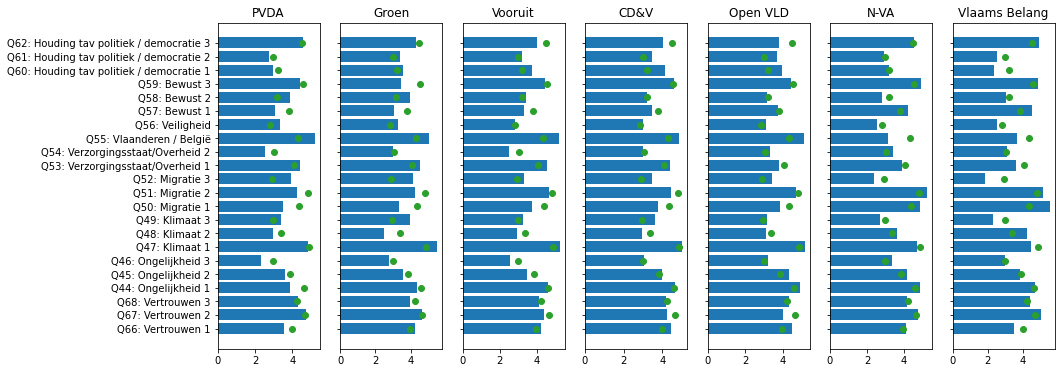

In [242]:
partijen_vandaag = ['PVDA', 'Groen', 'Vooruit', 'CD&V', 'Open VLD', 'N-VA', 'Vlaams Belang']

fig, axes = plt.subplots(1, len(partijen_vandaag), figsize=(15,6), sharey=True)

for i, partij_vandaag in enumerate(partijen_vandaag):
    if not partij_vandaag in ['PVDA', 'Groen', 'Vooruit', 'CD&V', 'Open VLD', 'N-VA', 'Vlaams Belang']: continue

    subset = data_cleaned.loc[(data_cleaned['Q7: voorkeur']==partij_vandaag),:]
    subset_mean_values = subset[columns_with_0_to_7_score].mean()
    
    axes[i].barh(width=subset_mean_values, tick_label=subset_mean_values.index, y=np.arange(len(subset_mean_values)))
    axes[i].scatter(x=aggregate_numbers['mean'], y=np.arange(len(subset_mean_values)), c='C2')
    axes[i].set_title(partij_vandaag)
    #'mean':data_cleaned[columns_with_0_to_7_score].mean().values


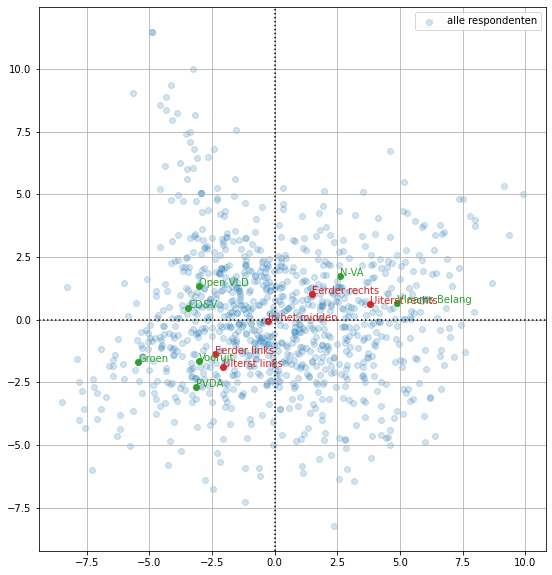

In [243]:
scaling_factor_partijen=2

fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.scatter(pca_components_respondents['pca_1'], pca_components_respondents['pca_2'], alpha=0.2, label="alle respondenten")

for zelf_ideologie in np.unique(data_cleaned['Q15: Ideologische zelfpositionering links/rechts']):
    
    row_mask = (data_cleaned['Q15: Ideologische zelfpositionering links/rechts']==zelf_ideologie)
    ax.scatter(pca_components_respondents.loc[row_mask.values,'pca_1'].mean(),
               pca_components_respondents.loc[row_mask.values,'pca_2'].mean(),
               c='C3')
    ax.text(pca_components_respondents.loc[row_mask.values,'pca_1'].mean(),
               pca_components_respondents.loc[row_mask.values,'pca_2'].mean(),
            s=zelf_ideologie,
               c='C3') 
    
for partij_vandaag in np.unique(data_cleaned['Q7: voorkeur']):
    if not partij_vandaag in ['PVDA', 'Groen', 'Vooruit', 'CD&V', 'Open VLD', 'N-VA', 'Vlaams Belang']: continue
    
    row_mask = data_cleaned['Q7: voorkeur']==partij_vandaag
    ax.scatter(pca_components_respondents.loc[row_mask.values,'pca_1'].mean()*scaling_factor_partijen,
               pca_components_respondents.loc[row_mask.values,'pca_2'].mean()*scaling_factor_partijen,
               c='C2')
    ax.text(pca_components_respondents.loc[row_mask.values,'pca_1'].mean()*scaling_factor_partijen,
               pca_components_respondents.loc[row_mask.values,'pca_2'].mean()*scaling_factor_partijen,
            s=partij_vandaag,
               c='C2') 
    
    
ax.grid()
ax.axvline(0, c='black', linestyle=':')
ax.axhline(0, c='black', linestyle=':')
ax.legend()
ax.set_aspect('equal')


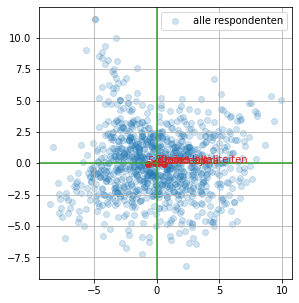

In [244]:
scaling_factor_partijen=2

fig, ax = plt.subplots(1,1, figsize=(5,5))

# Plot 1: minder vluchtelingen
row_mask = (data_cleaned['Q52: Migratie 3']==1)
ax.scatter(pca_components_respondents['pca_1'], pca_components_respondents['pca_2'], alpha=0.2, label="alle respondenten")

for habitat in np.unique(data_cleaned['Habitat']):
    
    row_mask = (data_cleaned['Habitat']==habitat)
    ax.scatter(pca_components_respondents.loc[row_mask.values,'pca_1'].mean(),
               pca_components_respondents.loc[row_mask.values,'pca_2'].mean(),
               c='C3')
    ax.text(pca_components_respondents.loc[row_mask.values,'pca_1'].mean(),
               pca_components_respondents.loc[row_mask.values,'pca_2'].mean(),
            s=habitat,
               c='C3') 
    
ax.grid()
ax.axvline(0, c='C2')
ax.axhline(0, c='C2')
ax.legend()
ax.set_aspect('equal')

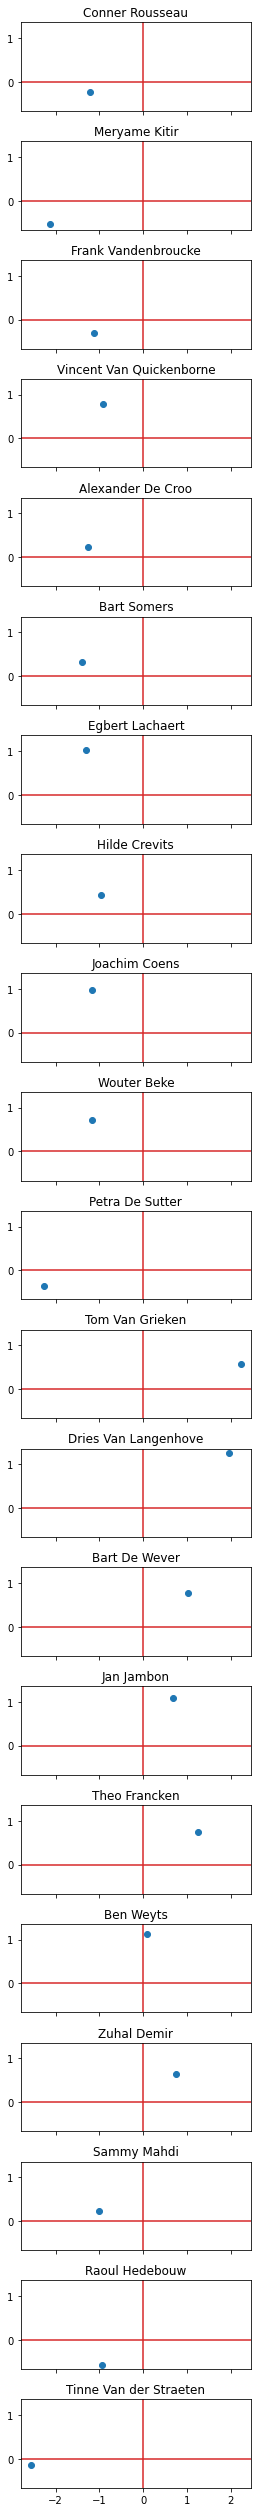

In [245]:

columns_politicians = [c for c in data_cleaned.columns if re.search('- potentieel', c)]

fig, axes = plt.subplots(len(columns_politicians), 1, figsize=(5,35), sharex=True, sharey=True)

for i, c in enumerate(columns_politicians):
    
    temp_politician = re.sub(' - potentieel', '', c)
    temp_politician = re.sub('Q[0-9]*: ', '', temp_politician)
    row_mask = (data_cleaned[c]=='Ja')
    axes[i].scatter(pca_components_respondents.loc[row_mask.values,'pca_1'].mean(),
                    pca_components_respondents.loc[row_mask.values,'pca_2'].mean())
    axes[i].set_aspect('equal')
    axes[i].axvline(0, c='C3')
    axes[i].axhline(0, c='C3')
    axes[i].set_title(temp_politician)
fig.tight_layout()

## Clustering van de vragen

In [281]:
from sklearn.cluster import FeatureAgglomeration

agglo = FeatureAgglomeration(n_clusters=5)
agglo.fit(data_cleaned[columns_with_0_to_7_score])


FeatureAgglomeration(n_clusters=5)

In [282]:
features_clustered = pd.DataFrame({'feature_cluster' : agglo.labels_,
                'features':columns_with_0_to_7_score})
features_clustered.sort_values('feature_cluster')

,feature_cluster,features
14,0,Q55: Vlaanderen / België
6,0,Q47: Klimaat 1
12,0,Q53: Verzorgingsstaat/Overheid 1
13,1,Q54: Verzorgingsstaat/Overheid 2
5,1,Q46: Ongelijkheid 3
7,1,Q48: Klimaat 2
10,2,Q51: Migratie 2
18,2,Q59: Bewust 3
16,2,Q57: Bewust 1
21,2,Q62: Houding tav politiek / democratie 3


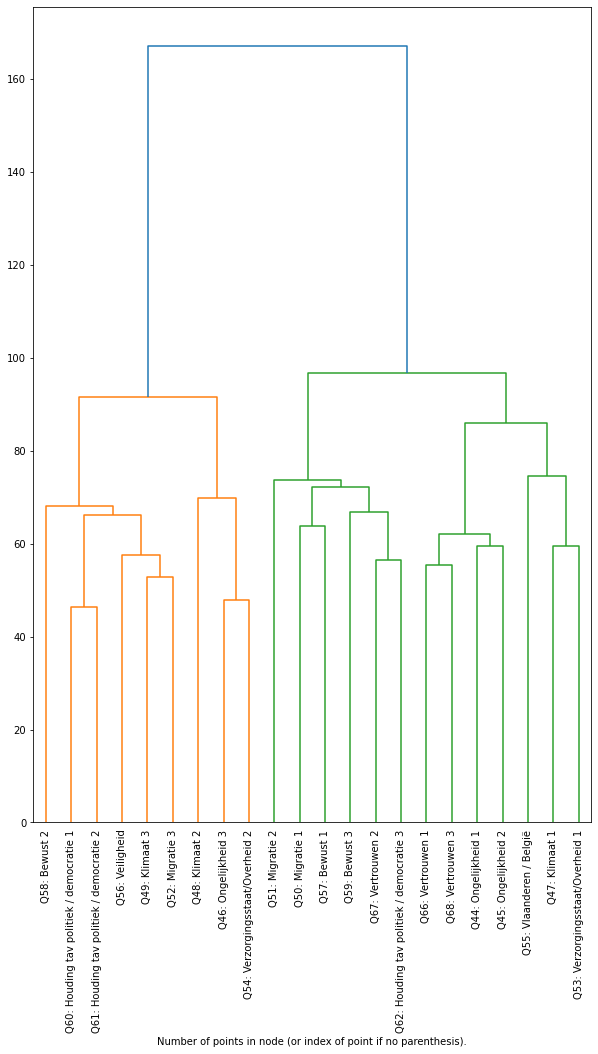

In [247]:
# Cluster de vragen

from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=3, compute_distances=True).fit(np.transpose(data_cleaned[columns_with_0_to_7_score].values))

from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs, ax=ax)

fig, ax = plt.subplots(1,1,figsize=(10,15))

plot_dendrogram(clustering, )
ax.set_xlabel("Number of points in node (or index of point if no parenthesis).")
ax.set_xticks([label.get_position()[0] for label in ax.xaxis.get_ticklabels()],
        labels=[columns_with_0_to_7_score[int(label.get_text())] for label in ax.xaxis.get_ticklabels()], rotation=90)
questions_clustered = pd.DataFrame({'question':data_cleaned[columns_with_0_to_7_score].columns,
              'cluster':clustering.labels_}).sort_values('cluster')



## Clustering van de users

In [283]:
aantal_clusters = 4

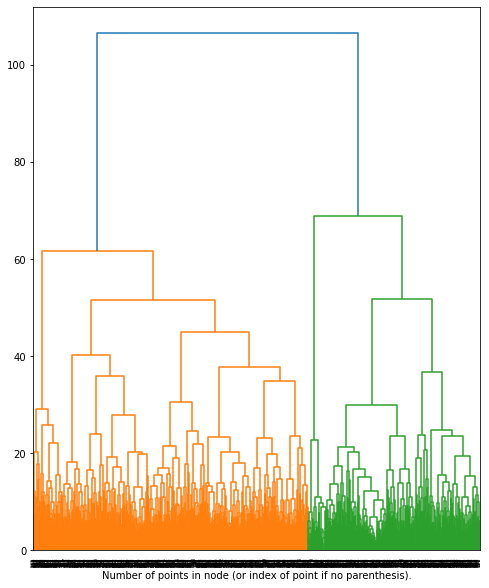

In [285]:
# Cluster de users

answers_wide_sample = data_cleaned[columns_with_0_to_7_score].copy()

from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=aantal_clusters, compute_distances=True).fit(answers_wide_sample)

from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs, ax=ax)

fig, ax = plt.subplots(1,1,figsize=(8,10))

plot_dendrogram(clustering, p=aantal_clusters)
ax.set_xlabel("Number of points in node (or index of point if no parenthesis).")

users_clustered = pd.DataFrame({'user':answers_wide_sample.index,
              'cluster':clustering.labels_})
users_clustered.columns = ['Respondent_Serial', 'cluster']
users_clustered = users_clustered.set_index('Respondent_Serial')
data_cleaned = data_cleaned.drop(columns=['cluster'], errors='ignore')
data_cleaned = pd.merge(data_cleaned, users_clustered, how='left', left_index=True, right_index=True)

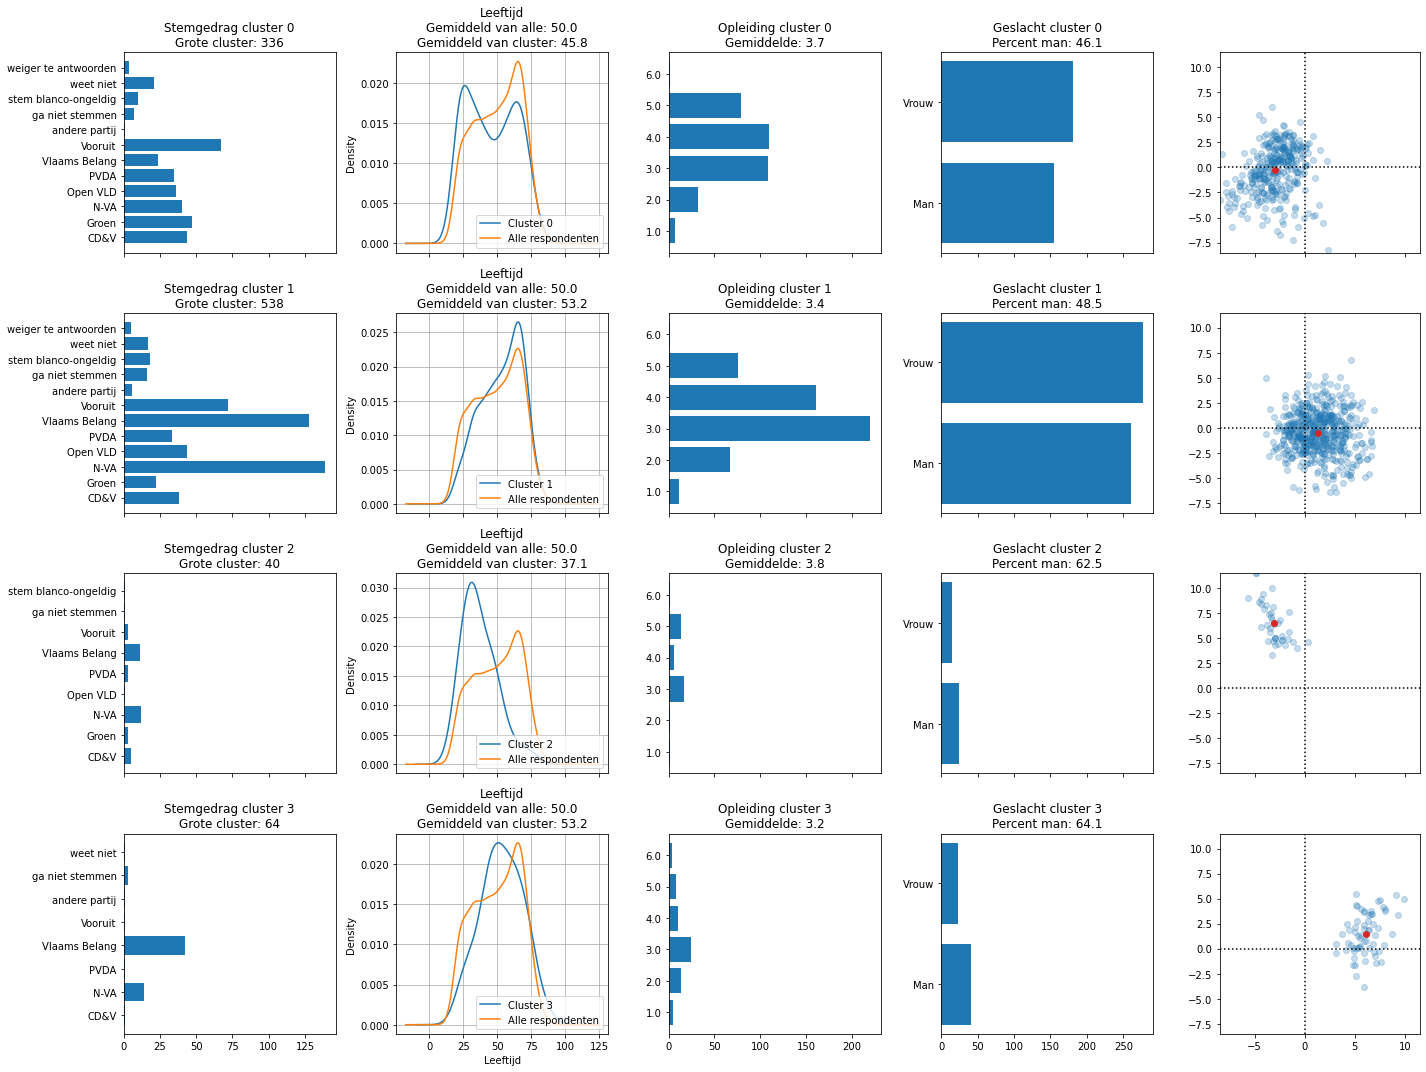

In [286]:
fig, axes = plt.subplots(len(np.unique(data_cleaned['cluster'])),5,figsize=(20,15), sharex='col')

for cluster in np.arange(len(np.unique(data_cleaned['cluster']))):
    
    cluster_subset = data_cleaned.loc[data_cleaned['cluster']==cluster,:]
    
    # Vote now
    cluster_value_counts_partijen = cluster_subset['Q7: voorkeur'].value_counts(ascending=True).sort_index()
    if('Vlaams Belang' not in cluster_value_counts_partijen):
        cluster_value_counts_partijen['Vlaams Belang'] = 0
    cluster_value_counts_partijen = cluster_value_counts_partijen.sort_index()   

    axes[cluster][0].barh(y=np.arange(len(cluster_value_counts_partijen)),
                          tick_label = cluster_value_counts_partijen.index,
                         width=cluster_value_counts_partijen)
    axes[cluster][0].set_title('Stemgedrag cluster {}\nGrote cluster: {}'.format(cluster, len(cluster_subset)))
    
    # Age
    cluster_subset['Leeftijd'].plot.kde(ax=axes[cluster][1], label='Cluster {}'.format(cluster))
    data_cleaned['Leeftijd'].plot.kde(ax=axes[cluster][1], label='Alle respondenten')
    axes[cluster][1].set_title('''Leeftijd\nGemiddeld van alle: {:.1f}\nGemiddeld van cluster: {:.1f}'''
                      .format(data_cleaned['Leeftijd'].mean(), cluster_subset['Leeftijd'].mean()), size=12)
    axes[cluster][1].legend(loc='lower right')
    axes[cluster][1].set_xlabel('Leeftijd')
    axes[cluster][1].grid()
    
    # Education
    cluster_value_counts_education = cluster_subset['Opleiding_num'].value_counts().sort_index()
    axes[cluster][2].barh(y=np.arange(len(cluster_value_counts_education)),
                          tick_label = cluster_value_counts_education.index,
                         width=cluster_value_counts_education)
    axes[cluster][2].set_title('Opleiding cluster {}\nGemiddelde: {:.1f}'.format(cluster, np.mean(cluster_subset['Opleiding_num']))) 
    
    # Sex
    cluster_value_counts_sex = cluster_subset['Geslacht'].value_counts().sort_index()
    axes[cluster][3].barh(y=np.arange(len(cluster_value_counts_sex)),
                          tick_label = cluster_value_counts_sex.index,
                         width=cluster_value_counts_sex)
    axes[cluster][3].set_title('Geslacht cluster {}\nPercent man: {:.1f}'.format(cluster, np.mean(cluster_subset['Geslacht']=='Man')*100))  
    
    # Latent features
    axes[cluster][4].scatter(cluster_subset['pca_1'], cluster_subset['pca_2'], alpha=0.25)
    axes[cluster][4].scatter(cluster_subset['pca_1'].mean(), cluster_subset['pca_2'].mean(), c='C3')
    axes[cluster][4].set_xlim(np.min(data_cleaned['pca_1']), np.max(data_cleaned['pca_2']))
    axes[cluster][4].set_ylim(np.min(data_cleaned['pca_1']), np.max(data_cleaned['pca_2']))    
    axes[cluster][4].set_aspect('equal')
    axes[cluster][4].axvline(0, linestyle=':', c='black')
    axes[cluster][4].axhline(0, linestyle=':', c='black')    
    
    # Belangrijkste thema
    #row_mask = raw_data['model_id'].isin(cluster_subset.index)
    #important_themas = pd.Series(raw_data.loc[row_mask, 'IssueSalience_1'].append(
    #                        raw_data.loc[row_mask, 'IssueSalience_2'])).value_counts()
    #for i, thema in enumerate(np.unique(raw_data['IssueSalience_1'].dropna())):
        #if(i==0): continue
    #    if(thema not in important_themas):
    #        important_themas[thema] = 0
    #important_themas.index = [int(i) for i in important_themas.index]
    #important_themas = important_themas.sort_index()
    #axes[cluster][5].barh(np.arange(len(important_themas)), width=important_themas.values, tick_label=important_themas.index)
    
fig.tight_layout()

## TSNE op vragen met scores 0-7

In [ ]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(data_cleaned[columns_with_0_to_7_score])
X_tsne = pd.DataFrame(X_embedded, columns=['tsne_1','tsne_2'], index=data_cleaned.index)

data_cleaned = data_cleaned.drop(columns=['tsne_1', 'tsne_2'], errors='ignore')
data_cleaned = pd.merge(data_cleaned, X_tsne, left_index=True, right_index=True)

fig, ax = plt.subplots(1,1,figsize=(7,7))

ax.scatter(data_cleaned['tsne_1'],data_cleaned['tsne_2'], alpha=0.25)

for partij_vandaag in np.unique(data_cleaned['Q7: voorkeur']):
    if not partij_vandaag in ['PVDA', 'Groen', 'Vooruit', 'CD&V', 'Open VLD', 'N-VA', 'Vlaams Belang']: continue
    
    row_mask = data_cleaned['Q7: voorkeur']==partij_vandaag
    ax.scatter(data_cleaned.loc[row_mask.values,'tsne_1'].mean()*scaling_factor_partijen,
               data_cleaned.loc[row_mask.values,'tsne_2'].mean()*scaling_factor_partijen,
               c='C3')
    ax.text(data_cleaned.loc[row_mask.values,'tsne_1'].mean()*scaling_factor_partijen,
               data_cleaned.loc[row_mask.values,'tsne_2'].mean()*scaling_factor_partijen,
            s=partij_vandaag,
               c='C3') 
ax.set_title('Dimension reduction with TSNE')
ax.set_aspect('equal')

## Predict partij vandaag

In [287]:
random_forest_data = data_cleaned.copy()
random_forest_data = random_forest_data.loc[random_forest_data['Q7: voorkeur'].isin(partijen_vandaag),:]

# Impute missings
random_forest_data['Inkomen_num'] = random_forest_data['Inkomen_num'].fillna(random_forest_data['Inkomen_num'].median())

# Set set to boolean
random_forest_data['Sex_boolean'] = random_forest_data['Geslacht']=='Vrouw'

random_forest_data.head()

,Geslacht,Leeftijd,Leeftijd categorie,Provincie,Habitat,Opleiding detail,Opleiding algemeen,Beroep detail,Beroep algemeen,Q5: Stemgerechtigd,Q6: Groen potentieel,Q6: CD&V potentieel,Q6: N-VA potentieel,Q6: Vooruit potentieel,Q6: VB potentieel,Q6: Open VLD potentieel,Q6: PVDA potentieel,Q7: voorkeur,Q9: aversie,Q10: stem 2019,Q12: reden switch,Q42: stemmen bij afschaffen opkomstplicht gemeenteraadsverkiezingen,Q15: Ideologische zelfpositionering links/rechts,Q23: Belang thema's - open,Q21: Belang thema’s,Q64: Klimaat - Thema eerst,Q65: Klimaat - Thema tweede,Q64: Migratie - Thema eerst,Q65: Migratie - Thema tweede,Q64: Sociale zekerheid - Thema eerst,Q65: Sociale zekerheid - Thema tweede,Q64: Pensioenen - Thema eerst,Q65: Pensioenen - Thema tweede,Q64: Gezondheidszorg - Thema eerst,Q65: Gezondheidszorg - Thema tweede,Q64: Werkgelegenheid - Thema eerst,Q65: Werkgelegenheid - Thema tweede,Q26: Beleid corona,Q43: Gevaccineerd,Q66: Vertrouwen 1,Q67: Vertrouwen 2,Q68: Vertrouwen 3,Q44: Ongelijkheid 1,Q45: Ongelijkheid 2,Q46: Ongelijkheid 3,Q47: Klimaat 1,Q48: Klimaat 2,Q49: Klimaat 3,Q50: Migratie 1,Q51: Migratie 2,Q52: Migratie 3,Q53: Verzorgingsstaat/Overheid 1,Q54: Verzorgingsstaat/Overheid 2,Q55: Vlaanderen / België,Q56: Veiligheid,Q57: Bewust 1,Q58: Bewust 2,Q59: Bewust 3,Q60: Houding tav politiek / democratie 1,Q61: Houding tav politiek / democratie 2,Q62: Houding tav politiek / democratie 3,Q28: Conner Rousseau - bekend,Q28: Meryame Kitir - bekend,Q28: Frank Vandenbroucke - bekend,Q28: Vincent Van Quickenborne - bekend,Q28: Alexander De Croo - bekend,Q28: Bart Somers - bekend,Q28: Egbert Lachaert - bekend,Q28: Hilde Crevits - bekend,Q28: Joachim Coens - bekend,Q28: Wouter Beke - bekend,Q28: Petra De Sutter - bekend,Q28: Tom Van Grieken - bekend,Q28: Dries Van Langenhove - bekend,Q28: Bart De Wever - bekend,Q28: Jan Jambon - bekend,Q28: Theo Francken - bekend,Q28: Ben Weyts - bekend,Q28: Zuhal Demir - bekend,Q28: Sammy Mahdi - bekend,Q28: Raoul Hedebouw - bekend,Q28: Tinne Van der Straeten - bekend,Q29: Conner Rousseau - potentieel,Q29: Meryame Kitir - potentieel,Q29: Frank Vandenbroucke - potentieel,Q29: Vincent Van Quickenborne - potentieel,Q29: Alexander De Croo - potentieel,Q29: Bart Somers - potentieel,Q29: Egbert Lachaert - potentieel,Q29: Hilde Crevits - potentieel,Q29: Joachim Coens - potentieel,Q29: Wouter Beke - potentieel,Q29: Petra De Sutter - potentieel,Q29: Tom Van Grieken - potentieel,Q29: Dries Van Langenhove - potentieel,Q29: Bart De Wever - potentieel,Q29: Jan Jambon - potentieel,Q29: Theo Francken - potentieel,Q29: Ben Weyts - potentieel,Q29: Zuhal Demir - potentieel,Q29: Sammy Mahdi - potentieel,Q29: Raoul Hedebouw - potentieel,Q29: Tinne Van der Straeten - potentieel,Q32: Frank Vandenbroucke - Indruk ministers,Q32: Alexander De Croo - Indruk ministers,Q32: Wouter Beke - Indruk ministers,Q32: Jan Jambon - Indruk ministers,Q32: Ben Weyts - Indruk ministers,Q33: Joris Vandenbroucke - bekend,Q33: Freya Vandenbossche - bekend,Q33: Astrid De Bruycker - bekend,Q33: Maxim Veys - bekend,Q33: Melissa Depraetere - bekend,Q33: Steve Vandenberghe - bekend,Q33: Annick Lambrecht - bekend,Q33: Bruno Tobback - bekend,Q33: Karin Jiroflee - bekend,Q33: Mohamed Ridouani - bekend,Q33: Kris Verduyckt - bekend,Q33: Ludwig Vandenhove - bekend,Q33: Els Robeyns - bekend,Q33: Tom Meeuws - bekend,Q33: Hannes Anaf - bekend,Q33: Caroline Gennez - bekend,Q33: Hannelore Goeman - bekend,Q33: Pablo Anys - bekend,Q36: Positieve woorden Vooruit,Q37: Negatieve woorden Vooruit,Q63: Vooruit is een partij die opkomt voor mensen zoals ik,Q63: Vooruit communiceert over het algemeen goed over haar standpunten en beleid,Q63: Vooruit heeft over het algemeen goede ideeën en voorstellen,Q63: Vooruit slaagt er over het algemeen goed in haar ideeën en voorstellen daadwerkelijk te realiseren,Q41: Inkomen,Opleiding_num,Inkomen_num,Partij_vandaag,pca_1,pca_2,pca_3,cluster,Sex_boolean
Respondent_Serial,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [288]:
features = ['Leeftijd', 'Opleiding_num', 'Inkomen_num', 'Sex_boolean', 'pca_1', 'pca_2', 'pca_3']
#features = columns_with_0_to_7_score

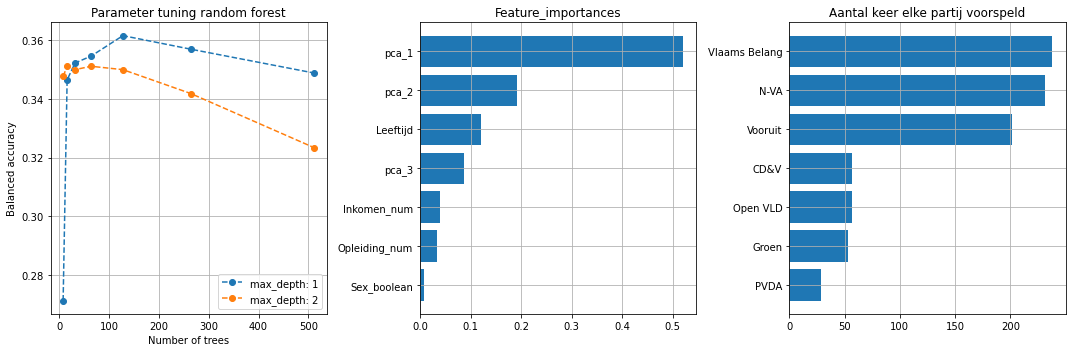

In [290]:
# Set classifier and parameters
classifier = GradientBoostingClassifier(subsample=0.9, max_features='sqrt')
parameters = {'n_estimators':[8,16,32,64, 128, 264, 512],
                'max_depth':[1,2]}

# Train gridsearch
classifier_gridsearch = GridSearchCV(classifier, parameters, cv=5, scoring='accuracy')
classifier_gridsearch.fit(random_forest_data[features], random_forest_data['Q7: voorkeur'])
cv_results = pd.DataFrame(classifier_gridsearch.cv_results_)

# Feature imortances
importances = pd.Series(classifier_gridsearch.best_estimator_.feature_importances_, index=features).sort_values()

# Cross val predict
random_forest_data['partij_prediction'] = cross_val_predict(estimator=classifier_gridsearch.best_estimator_, 
                                                               X=random_forest_data[features], 
                                                               y=random_forest_data['Q7: voorkeur'])
predictions_value_counts = random_forest_data['partij_prediction'].value_counts().sort_values()

# Plots
fig, axes = plt.subplots(1,3, figsize=(15,5))

for max_depth in np.unique(cv_results['param_max_depth']):
    subset = cv_results.loc[(cv_results['param_max_depth'] == max_depth),:]
    axes[0].plot(subset['param_n_estimators'], subset['mean_test_score'], linestyle='--', marker='o', label=f'max_depth: {max_depth}')
axes[0].legend()
axes[0].set_xlabel('Number of trees')
axes[0].set_ylabel('Balanced accuracy')
axes[0].set_title('Parameter tuning gradient boosting', size=12)
axes[0].grid()

axes[1].barh(y=np.arange(len(importances)), width=importances, tick_label=importances.index, color='C0')
axes[1].set_title('Feature_importances', size=12)
axes[1].grid()

axes[2].barh(y=np.arange(len(predictions_value_counts)), width=predictions_value_counts, tick_label=predictions_value_counts.index, color='C0')
axes[2].set_title('Aantal keer elke partij voorspeld', size=12)
axes[2].grid()

fig.tight_layout()

/Users/kasper/miniconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


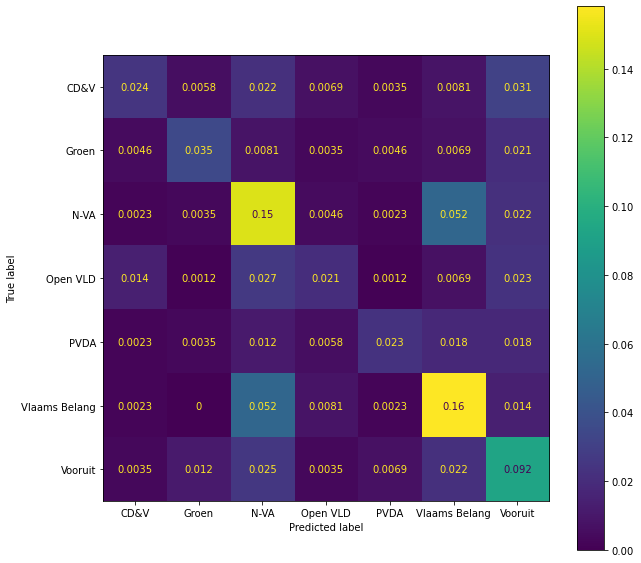

In [291]:
#
#predictions_value_counts.index = partij_num_dict.keys()

fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_confusion_matrix(classifier_gridsearch.best_estimator_,
                     X=random_forest_data[features], 
                    y_true=random_forest_data['Q7: voorkeur'], 
                 normalize='all', ax=ax, )

#no_print = ax.set_xticklabels(labels=partij_num_dict.keys(), rotation=45)
#no_print = ax.set_yticklabels(labels=partij_num_dict.keys(), rotation=45)